# Credit Scoring Individual Assignment

### Chenxin Xie

This project amis to develop an application credit scorecard for a financial institution which extends loans to subprime customers (pay-day loans).
We will first look into the data and pre-process the data, then perform different models and evalute each model's performance, and finally choose the best one to be our final scorecard.

In [204]:
# Load library
library(xlsx)
library(tidyverse)
library(ggplot2)
library(ggpubr)
theme_set(theme_pubr())
library(caret)
library(plyr) 
library(Information)
library(MASS)
library(knitr)
library(scorecard)
library(ggplot2) 
library(gtools)
library(mlr)
library(woeBinning)
library(data.table)
library(dataPreparation)
library(logistf)
library(pROC)
library(randomForest)
library(ROCR)
library(rpart)
library(rpart.plot)
library(stringr)
library(naivebayes)

Warning message:
"package 'naivebayes' was built under R version 3.6.3"naivebayes 0.9.7 loaded

Attaching package: 'naivebayes'

The following object is masked from 'package:data.table':

    tables



In [203]:
#install.packages("naivebayes")

### 1. Data Exploration and Cleaning

#### Read in data

In [2]:
setwd("C:/Users/cxie/Desktop/Credit scoring/")

In [3]:
accept = read.xlsx ("ACCEPTS.xlsx", sheetName = "Dataset", header = TRUE)
head(accept)

ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,Days_late,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,Default_45
250263,1,1,11,5,6,7,1,2,0,1,0,NA,1.4385177,-0.25908469,1.7810399,0.8602691,0.5139798,0
250290,1,2,6,4,5,1,1,2,1,1,0,1.4981826,0.2048114,0.38331185,1.1071627,-0.7182492,1.7965902,0
250249,2,3,11,5,7,7,1,2,1,1,0,-0.2417306,-0.8526511,-0.73242952,1.4066637,1.1229297,-0.7686307,0
249516,3,3,10,4,2,4,1,2,0,1,168,NA,-0.6764074,-0.05734964,0.9574122,-1.7024817,0.5139798,1
249827,1,3,5,2,4,4,1,3,0,1,0,NA,-0.4120417,-0.57464791,-0.3903424,0.9100767,-0.7686307,0
250329,1,3,11,2,5,4,3,4,0,2,0,NA,0.5572989,-0.21062320,-0.3903424,-0.3844956,0.5139798,0


The independent variable is "Default_45", 0 means no defalut and 1 means default.

In [4]:
dim(accept)

[1] 10000    19

In [5]:
reject = read.xlsx ("REJECTS.xlsx", sheetName = "Dataset", header = TRUE)
head(reject)

ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
305932,3,3,14,2,1,5,1,1,1,1,-0.03045546,-0.3239198,-0.6054491,-1.06421961,1.02821012,-0.7686307
305764,1,4,7,1,6,4,1,2,1,1,0.71522164,5.6683677,1.2995722,0.80766165,1.08177814,1.7965902
305971,1,4,10,4,5,4,1,4,1,3,0.76493345,-0.7507822,0.4340274,-0.39034236,-0.96941579,1.7965902
305664,1,5,14,2,2,5,3,3,1,1,-1.34781834,-0.8526511,-0.4901220,-0.98934436,1.04630263,-0.7686307
305639,1,4,15,1,5,4,1,3,1,2,1.63489006,3.2009552,0.5613797,0.58303590,0.08846388,1.7965902
305854,3,3,10,1,4,5,3,1,1,1,0.97620862,0.2929333,-0.5059002,0.05890915,1.02182453,-0.7686307


In [6]:
dim(reject)

[1] 5000   17

#### Acceptance rate

In [12]:
acceptance_rate <- round(dim(accept)[1]/(dim(accept)[1]+dim(reject)[1]), 2)
acceptance_rate

[1] 0.67

In this project, the acceptance rate is 67%, which also indicates the reject rate is 23%.

In [5]:
str(accept)

'data.frame':	10000 obs. of  19 variables:
 $ ID                 : num  250263 250290 250249 249516 249827 ...
 $ V1                 : num  1 1 2 3 1 1 2 1 2 3 ...
 $ V2                 : num  1 2 3 3 3 3 4 3 5 3 ...
 $ V3                 : num  11 6 11 10 5 11 11 12 11 14 ...
 $ V4                 : num  5 4 5 4 2 2 5 3 5 1 ...
 $ V5                 : num  6 5 7 2 4 5 7 3 1 4 ...
 $ V6                 : num  7 1 7 4 4 4 7 5 7 4 ...
 $ V7                 : num  1 1 1 1 1 3 3 1 1 3 ...
 $ V8                 : Factor w/ 5 levels ">4","1","2","3",..: 3 3 3 3 4 5 2 4 2 2 ...
 $ Has_FICO           : num  0 1 1 0 0 0 1 0 0 0 ...
 $ Business_channel   : num  1 1 1 1 1 2 1 2 1 1 ...
 $ Days_late          : num  0 0 0 168 0 0 0 0 336 0 ...
 $ FICO_Score         : num  NA 1.498 -0.242 NA NA ...
 $ Loan_amount        : num  1.439 0.205 -0.853 -0.676 -0.412 ...
 $ Monthly_income     : num  -0.2591 0.3833 -0.7324 -0.0573 -0.5746 ...
 $ Age                : num  1.781 1.107 1.407 0.957 -0.39 ...
 $ 

From the summary of the data, we can that some variables are on different scales.   
Variables 'FICO_Score', 'Loan_amount', 'Monthly_income', 'Age', 'Gearing_coefficient' and 'Max_gearing_ratio' have been normalized.   
The target variable is the "Default_45", 1 means default and 0 means no default.   
We will have a look at the distribution of defalut(1) and no default(0)

In [7]:
# convert target variable 
# accept$Default_45<-as.factor(ifelse(accept$Default_45 == 1, "Default", "NoDefalut"))

We will have a look at the distribution of Defalut and NoDdefault.

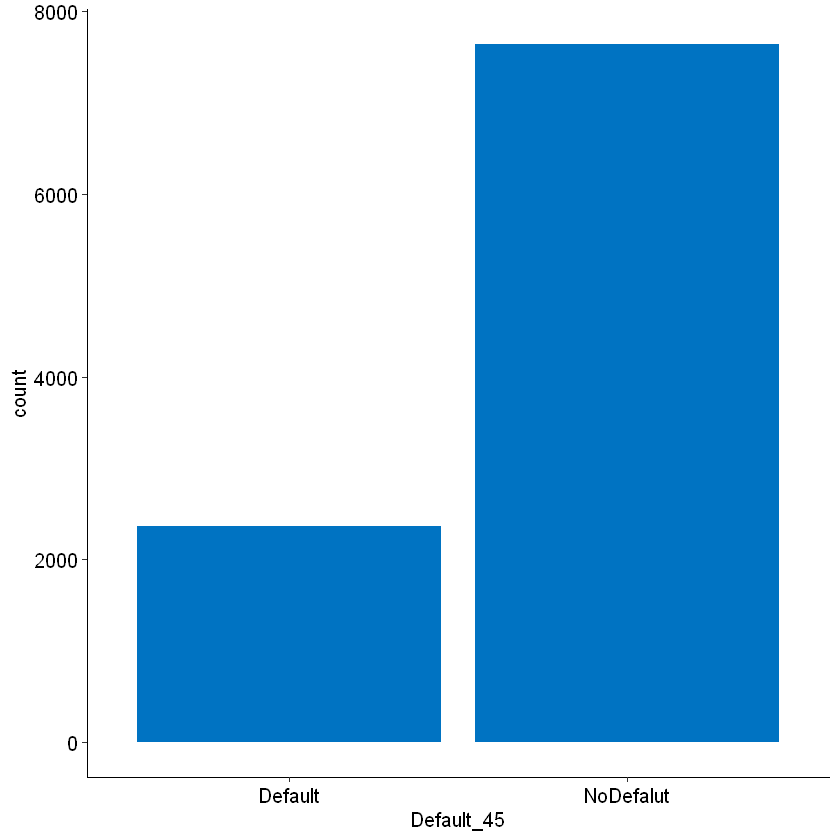

In [8]:
ggplot(accept, aes(Default_45)) +
  geom_bar(fill = "#0073C2FF")

#### Bad rate

In [39]:
# check by percentage
table(accept$Default_45) / nrow(accept)


     0      1 
0.7636 0.2364 

We can see that there are about 76% of the customers did not default and about 24% of the customers defaulted.    
So the Bad rate of this project is 23.64%.

#### Check missing values

In [34]:
na_rate <- function(x) {x %>% is.na() %>% sum() / length(x)}
sapply(accept, na_rate) %>% round(2)

ID                  V1                  V2                  V3 
               0.00                0.00                0.00                0.00 
                 V4                  V5                  V6                  V7 
               0.00                0.00                0.00                0.00 
                 V8            Has_FICO    Business_channel           Days_late 
               0.00                0.00                0.00                0.00 
         FICO_Score         Loan_amount      Monthly_income                 Age 
               0.45                0.00                0.00                0.00 
Gearing_coefficient   Max_gearing_ratio          Default_45 
               0.00                0.00                0.00

There are about 45% missing values in variable "FICO_Score" in the accept dataset.

In [35]:
summary(accept$FICO_Score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -6.033  -0.876  -0.192  -0.083   0.690   2.468    4472 

We can see that the values of FICO_Score are in the range from -6.033 to 2.468, therefore, we can not replace the missing values with 0. A better way is to replace by mean.

In [13]:
# replace missing value with mean
accept[is.na(accept[ , "FICO_Score"]) , "FICO_Score"] <- mean(accept[ , "FICO_Score"], na.rm = TRUE)
summary(accept$FICO_Score)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-6.03316 -0.32873 -0.08326 -0.08326 -0.00560  2.46756 

In [11]:
summary(accept[,-1])

       V1              V2              V3               V4       
 Min.   :1.000   Min.   :1.000   Min.   : 1.000   Min.   :1.000  
 1st Qu.:1.000   1st Qu.:3.000   1st Qu.: 7.000   1st Qu.:2.000  
 Median :1.000   Median :3.000   Median :10.000   Median :4.000  
 Mean   :1.879   Mean   :3.495   Mean   : 9.041   Mean   :3.316  
 3rd Qu.:3.000   3rd Qu.:5.000   3rd Qu.:11.000   3rd Qu.:4.000  
 Max.   :5.000   Max.   :6.000   Max.   :16.000   Max.   :6.000  
       V5              V6              V7         V8          Has_FICO     
 Min.   :1.000   Min.   :1.000   Min.   :1.000   >4: 182   Min.   :0.0000  
 1st Qu.:2.000   1st Qu.:4.000   1st Qu.:1.000   1 :3703   1st Qu.:0.0000  
 Median :4.000   Median :5.000   Median :1.000   2 :3787   Median :1.0000  
 Mean   :3.977   Mean   :4.868   Mean   :1.757   3 :1486   Mean   :0.5528  
 3rd Qu.:6.000   3rd Qu.:5.000   3rd Qu.:3.000   4 : 842   3rd Qu.:1.0000  
 Max.   :7.000   Max.   :7.000   Max.   :3.000             Max.   :1.0000  
 Busin

We can see that variable "Days_late" has outliners.    
"V8" is categorical.     
"Has_FICO" is a binary variable.    
"Business_channel" is catgorical variable.    
We will first deal with the outliners first.

#### Transform Days_late

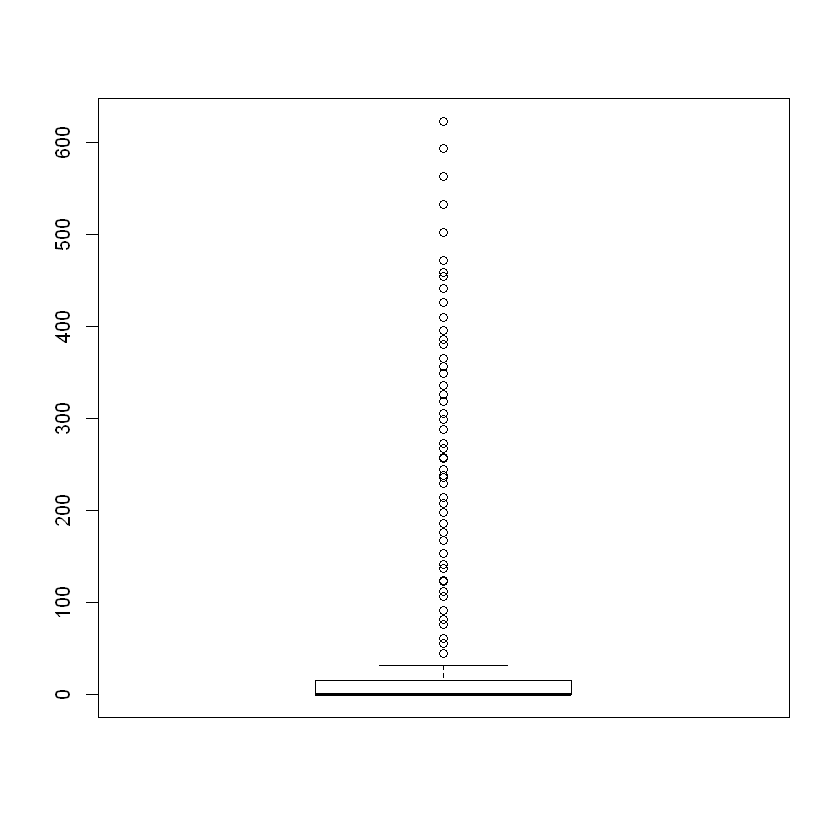

In [128]:
boxplot(accept$Days_late)

In [14]:
# scale 'Day_late'
accept$Days_late <- scale(accept$Days_late)

In [6]:
summary(accept$Days_late)

       V1         
 Min.   :-0.4817  
 1st Qu.:-0.4817  
 Median :-0.4817  
 Mean   : 0.0000  
 3rd Qu.:-0.3537  
 Max.   : 4.8333  

### 2. Data Transformation — Weight of Evidence Method

From the data description, FICO_Score, Loan_amount, Monthly_income, Age, Gearing_coefficient and Max_gearing_ratio have been normalized, we will particularly transform V8, Has_FICO and Business_channel with WoE.

#### Transformation of V8

In [15]:
# Build the dummy encoding
encoding <- build_encoding(dataSet=accept, cols="V8", verbose=F)
# Transform the categorical variable
D_V8 <- one_hot_encoder(dataSet=accept, encoding=encoding, type='logical', drop=F, verbose=F)
D_V8 <- D_V8[, 20:24]
head(D_V8)

Warning message in setDT(dataSet):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

V8..4,V8.1,V8.2,V8.3,V8.4
FALSE,FALSE,TRUE,FALSE,FALSE
FALSE,FALSE,TRUE,FALSE,FALSE
FALSE,FALSE,TRUE,FALSE,FALSE
FALSE,FALSE,TRUE,FALSE,FALSE
FALSE,FALSE,FALSE,TRUE,FALSE
FALSE,FALSE,FALSE,FALSE,TRUE


In [16]:
# Find the incidence rates of V8
tbV8 <- table(accept$V8, accept$Default_45)
incidence_map_V8 <- data.frame('v1'=rownames(tbV8), 'v2'=tbV8[, '1'] / (tbV8[, '0'] + tbV8[, '1']))
colnames(incidence_map_V8) <- c('V8', 'V8_incidence')
incidence_map_V8

,V8,V8_incidence
>4,>4,0.2692308
1,1,0.3038077
2,2,0.1866913
3,3,0.1985195
4,4,0.2232779


In [17]:
# Convert the V8 categories with incidences
D_V8 <- plyr::join(x=accept, y=incidence_map_V8, by='V8', type="left", match="all")
head(D_V8[, c('V8', 'V8_incidence')])

Warning message in setDT(ans, key = key):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

V8,V8_incidence
2,0.1866913
2,0.1866913
2,0.1866913
2,0.1866913
3,0.1985195
4,0.2232779


In [18]:
# Find the WOE of V8
tbV8 <- table(accept$V8, accept$Default_45)
woe_map_V8 <- data.frame('v1'=rownames(tbV8), 'v2'=log(tbV8[, '1'] / tbV8[, '0']))
colnames(woe_map_V8) <- c('V8', 'V8_woe')
woe_map_V8

,V8,V8_woe
>4,>4,-0.9985288
1,1,-0.8292309
2,2,-1.4716542
3,3,-1.3955732
4,4,-1.2466654


In [19]:
# Convert the V8 categories with WOE
D_V8 <- plyr::join(x=accept, y=woe_map_V8, by='V8', type="left", match="all")
head(D_V8[, c('V8', 'V8_woe')])

Warning message in setDT(ans, key = key):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

V8,V8_woe
2,-1.471654
2,-1.471654
2,-1.471654
2,-1.471654
3,-1.395573
4,-1.246665


Here we have transformed categorical variable 'V8' with woe.

#### Transformation of Has_FICO

In [20]:
# convert to factor
accept$Has_FICO <- as.factor(accept$Has_FICO)
# Build the dummy encoding
encoding <- build_encoding(dataSet=accept, cols="Has_FICO", verbose=F)
# Transform the categorical variable
D_HF <- one_hot_encoder(dataSet=accept, encoding=encoding, type='logical', drop=F, verbose=F)
D_HF <- D_HF[, 20:21]
head(D_HF)

Has.FICO.0,Has.FICO.1
TRUE,FALSE
FALSE,TRUE
FALSE,TRUE
TRUE,FALSE
TRUE,FALSE
TRUE,FALSE


In [21]:
# Find the incidence rates of Has_FICO
tbHF <- table(accept$Has_FICO, accept$Default_45)
incidence_map_HF <- data.frame('v1'=rownames(tbHF), 'v2'=tbHF[, '1'] / (tbHF[, '0'] + tbHF[, '1']))
colnames(incidence_map_HF) <- c('Has_FICO', 'Has_FICO_incidence')
incidence_map_HF

,Has_FICO,Has_FICO_incidence
0,0,0.2576029
1,1,0.2192475


In [22]:
# Convert the Has_FICO categories with incidences
D_HF <- plyr::join(x=accept, y=incidence_map_HF, by='Has_FICO', type="left", match="all")
head(D_HF[, c('Has_FICO', 'Has_FICO_incidence')])

Warning message in setDT(ans, key = key):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

Has_FICO,Has_FICO_incidence
0,0.2576029
1,0.2192475
1,0.2192475
0,0.2576029
0,0.2576029
0,0.2576029


In [23]:
# Find the WOE of Has_FICO
tbHF <- table(accept$Has_FICO, accept$Default_45)
woe_map_HF <- data.frame('v1'=rownames(tbHF), 'v2'=log(tbHF[, '1'] / tbHF[, '0']))
colnames(woe_map_HF) <- c('Has_FICO', 'Has_FICO_woe')
woe_map_HF

,Has_FICO,Has_FICO_woe
0,0,-1.058465
1,1,-1.270057


In [24]:
# Convert the Has_FICO categories with WOE
D_HF <- plyr::join(x=accept, y=woe_map_HF, by='Has_FICO', type="left", match="all")
head(D_HF[, c('Has_FICO', 'Has_FICO_woe')])

Warning message in setDT(ans, key = key):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

Has_FICO,Has_FICO_woe
0,-1.058465
1,-1.270057
1,-1.270057
0,-1.058465
0,-1.058465
0,-1.058465


#### Transformation of  Business_channel

In [25]:
# convert to factor
accept$Business_channel <- as.factor(accept$Business_channel)
# Build the dummy encoding
encoding <- build_encoding(dataSet=accept, cols="Business_channel", verbose=F)
# Transform the categorical variable
D_BC <- one_hot_encoder(dataSet=accept, encoding=encoding, type='logical', drop=F, verbose=F)
D_BC <- accept[, 22:24]
head(D_BC)

Business.channel.1,Business.channel.2,Business.channel.3
TRUE,FALSE,FALSE
TRUE,FALSE,FALSE
TRUE,FALSE,FALSE
TRUE,FALSE,FALSE
TRUE,FALSE,FALSE
FALSE,TRUE,FALSE


In [26]:
# Find the incidence rates of Business_channel
tbBC <- table(accept$Business_channel, accept$Default_45)
incidence_map_BC <- data.frame('v1'=rownames(tbBC), 'v2'=tbBC[, '1'] / (tbBC[, '0'] + tbBC[, '1']))
colnames(incidence_map_BC) <- c('Business_channel', 'Business_channel_incidence')
incidence_map_BC

Business_channel,Business_channel_incidence
1,0.20601852
2,0.39972015
3,0.08792373


In [27]:
# Convert the Business_channel categories with incidences
D_BC <- plyr::join(x=accept, y=incidence_map_BC, by='Business_channel', type="left", match="all")
head(D_BC[, c('Business_channel', 'Business_channel_incidence')])

Warning message in setDT(ans, key = key):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

Business_channel,Business_channel_incidence
1,0.2060185
1,0.2060185
1,0.2060185
1,0.2060185
1,0.2060185
2,0.3997201


In [28]:
# Find the WOE of Business_channel
tbBC <- table(accept$Business_channel, accept$Default_45)
woe_map_BC <- data.frame('v1'=rownames(tbBC), 'v2'=log(tbBC[, '1'] / tbBC[, '0']))
colnames(woe_map_BC) <- c('Business_channel', 'Business_channel_woe')
woe_map_BC

Business_channel,Business_channel_woe
1,-1.3490941
2,-0.4066313
3,-2.3392539


In [29]:
# Convert the Business_channel categories with WOE
D_BC <- plyr::join(x=accept, y=woe_map_BC, by='Business_channel', type="left", match="all")  # Left join
head(D_BC[, c('Business_channel', 'Business_channel_woe')])

Warning message in setDT(ans, key = key):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

Business_channel,Business_channel_woe
1,-1.3490941
1,-1.3490941
1,-1.3490941
1,-1.3490941
1,-1.3490941
2,-0.4066313


Now we have transformed the cateforical variables with woe.   
Then we will standize the other numerical variables.

#### Standardize numerical variable which has not been normalized

In [30]:
accept[, 'V1'] <- scale(accept[, 'V1'], center=T, scale=T) 
accept[, 'V2'] <- scale(accept[, 'V2'], center=T, scale=T) 
accept[, 'V3'] <- scale(accept[, 'V3'], center=T, scale=T) 
accept[, 'V4'] <- scale(accept[, 'V4'], center=T, scale=T) 
accept[, 'V5'] <- scale(accept[, 'V5'], center=T, scale=T) 
accept[, 'V6'] <- scale(accept[, 'V6'], center=T, scale=T)
accept[, 'V7'] <- scale(accept[, 'V7'], center=T, scale=T) 
summary(accept)

       ID               V1                V2                V3         
 Min.   :249516   Min.   :-0.8044   Min.   :-2.0644   Min.   :-2.1598  
 1st Qu.:269470   1st Qu.:-0.8044   1st Qu.:-0.4098   1st Qu.:-0.5483  
 Median :284845   Median :-0.8044   Median :-0.4098   Median : 0.2575  
 Mean   :282248   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:296045   3rd Qu.: 1.0265   3rd Qu.: 1.2447   3rd Qu.: 0.5261  
 Max.   :305957   Max.   : 2.8573   Max.   : 2.0720   Max.   : 1.8690  
       V4                V5                V6                 V7         
 Min.   :-1.7011   Min.   :-1.4619   Min.   :-2.80581   Min.   :-0.7896  
 1st Qu.:-0.9666   1st Qu.:-0.9709   1st Qu.:-0.62981   1st Qu.:-0.7896  
 Median : 0.5022   Median : 0.0111   Median : 0.09553   Median :-0.7896  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.5022   3rd Qu.: 0.9931   3rd Qu.: 0.09553   3rd Qu.: 1.2960  
 Max.   : 1.9710   Max.   : 1.4841   Max.   : 1.5461

#### Mereg all the transformed vairable with the remaining variables

In [31]:
df <- cbind(accept[, c("ID", "V1", "V2", "V3", "V4", "V5", "V6", "V7")], 
            D_V8[, 'V8_woe'], D_HF[, 'Has_FICO_woe'], D_BC[, 'Business_channel_woe'], 
            accept[, c("Days_late", "FICO_Score", "Loan_amount", "Monthly_income", "Age", "Gearing_coefficient", "Max_gearing_ratio", "Default_45")])

Warning message in setDT(ans, key = key):
"Some columns are a multi-column type (such as a matrix column): [12]. setDT will retain these columns as-is but subsequent operations like grouping and joining may fail. Please consider as.data.table() instead which will create a new column for each embedded column."

In [32]:
head(df)

ID,V1,V2,V3,V4,V5,V6,V7,V8_woe,Has_FICO_woe,Business_channel_woe,Days_late,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,Default_45
250263,-0.8043865,-2.0644126,0.5260518,1.2366172,0.99310611,1.5461945,-0.789633,-1.471654,-1.058465,-1.3490941,-0.4816657,-0.08325627,1.4385177,-0.25908469,1.7810399,0.8602691,0.5139798,0
250290,-0.8043865,-1.2371253,-0.8168764,0.5021967,0.50210141,-2.8058096,-0.789633,-1.471654,-1.270057,-1.3490941,-0.4816657,1.49818259,0.2048114,0.38331185,1.1071627,-0.7182492,1.7965902,0
250249,0.1110414,-0.4098381,0.5260518,1.2366172,1.48411081,1.5461945,-0.789633,-1.471654,-1.270057,-1.3490941,-0.4816657,-0.24173064,-0.8526511,-0.73242952,1.4066637,1.1229297,-0.7686307,0
249516,1.0264693,-0.4098381,0.2574662,0.5021967,-0.97091270,-0.6298075,-0.789633,-1.471654,-1.058465,-1.3490941,0.9515788,-0.08325627,-0.6764074,-0.05734964,0.9574122,-1.7024817,0.5139798,1
249827,-0.8043865,-0.4098381,-1.0854620,-0.9666443,0.01109671,-0.6298075,-0.789633,-1.395573,-1.058465,-1.3490941,-0.4816657,-0.08325627,-0.4120417,-0.57464791,-0.3903424,0.9100767,-0.7686307,0
250329,-0.8043865,-0.4098381,0.5260518,-0.9666443,0.50210141,-0.6298075,1.296033,-1.246665,-1.058465,-0.4066313,-0.4816657,-0.08325627,0.5572989,-0.21062320,-0.3903424,-0.3844956,0.5139798,0


The final table after data processing is done. We can see that all the variables are either nomalized, standardized or tfansformed with woe.    
We can then split the data into train and test and perform feature selection before modeling.

#### split data into train and test

In [33]:
# spiltting and resampling into train (60%) and test (40%)
set.seed(123)
trainIndex <- createDataPartition(df$Default_45, p = 0.6, list = FALSE, times = 1)
train <- df[trainIndex, ]
test <- df[-trainIndex, ]

#### check distribution of default in train and test

In [34]:
# train
ddply(train, "Default_45", summarise, count = length(Default_45), 
    percentage = round(length(Default_45)/nrow(train), 2))

Default_45,count,percentage
0,4549,0.76
1,1451,0.24


In [35]:
# test
ddply(test, "Default_45", summarise, count = length(Default_45), 
    percentage = round(length(Default_45)/nrow(test), 2))

Default_45,count,percentage
0,3087,0.77
1,913,0.23


We can see the train and test data have been splited with similar distribution of Default_45.

### 3. Feature Selection using Information Value

We will use Information Value to find out the better prediction power predictors for modeling.

In [37]:
IV <- create_infotables(data=train[, -1], y="Default_45")

In [38]:
IV$Summary$IV <- round(IV$Summary$IV*100,2)
IV$Table

V1,N,Percent,WOE,IV
"[-0.8,-0.8]",3448,0.57466667,-0.3094677,0.05059094
"[0.11,0.11]",301,0.05016667,-0.2899640,0.05448977
"[1.03,2.86]",2251,0.37516667,0.4267638,0.12999419
V2,N,Percent,WOE,IV
"[-2.06,-1.24]",801,0.1335000,-0.5739456,0.03741186
"[-0.41,-0.41]",2305,0.3841667,0.1251294,0.04361932
"[0.42,0.42]",1365,0.2275000,-0.3281973,0.06602496
"[1.24,2.07]",1529,0.2548333,0.3056131,0.09164880
V3,N,Percent,WOE,IV
"[-2.16,-2.16]",114,0.01900000,-0.28809167,0.001458397


From this table we can see the WOE and IV of every combination in each variable.

In [39]:
kable(IV$Summary)



|   |Variable             |    IV|
|:--|:--------------------|-----:|
|12 |FICO_Score           | 65.67|
|5  |V5                   | 29.21|
|15 |Age                  | 28.22|
|10 |Business_channel_woe | 25.33|
|6  |V6                   | 22.48|
|4  |V4                   | 13.68|
|1  |V1                   | 13.00|
|2  |V2                   |  9.16|
|3  |V3                   |  8.77|
|7  |V7                   |  8.32|
|8  |V8_woe               |  7.82|
|11 |Days_late            |  5.31|
|13 |Loan_amount          |  4.58|
|14 |Monthly_income       |  2.97|
|9  |Has_FICO_woe         |  1.66|
|16 |Gearing_coefficient  |  1.58|
|17 |Max_gearing_ratio    |  0.44|

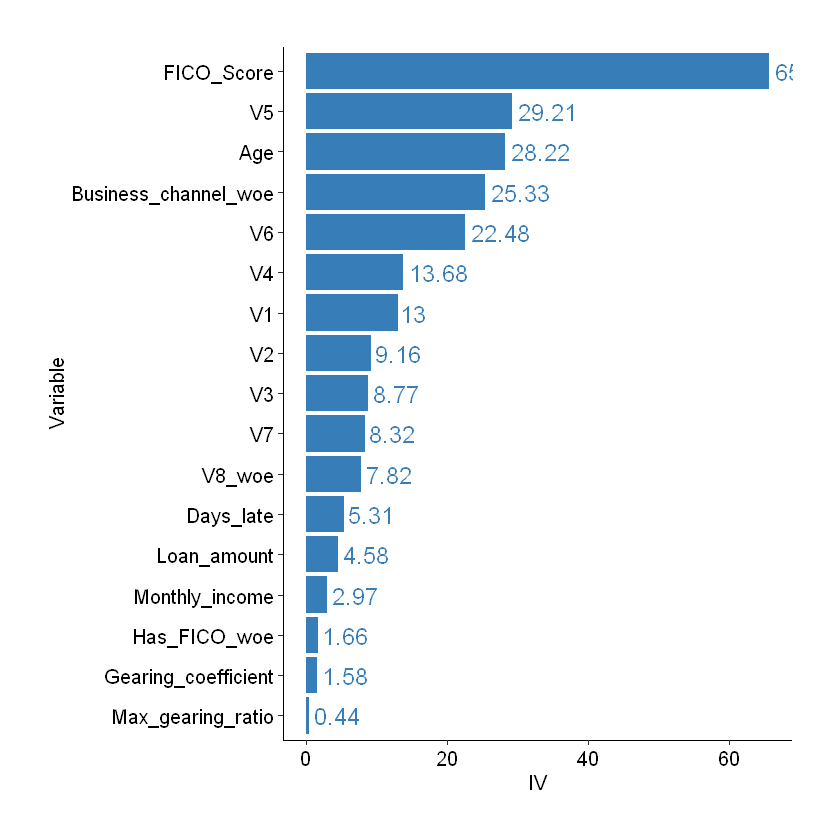

In [40]:
IV$Summary %>% arrange(IV) %>% 
  mutate(info_value = round(IV, 2), Variable = factor(Variable, levels = Variable)) %>% 
  ggplot(aes(Variable, IV)) + 
  geom_col(fill = "#377eb8") + 
  coord_flip() + 
  geom_text(aes(label = IV), hjust = -.1, size = 5, color = "#377eb8") + 
  theme(panel.grid.major.y = element_blank()) + 
  theme(plot.margin = unit(c(1, 1, 1, 1), "cm")) 

From the table above, it shows the ranking of predictive power of the variables.    
"FICO_Score" has a very strong prediction power (IV > 50%), which is suspicious.   
"V5", "Age", "Business_channel_woe", "V6", "V4" and "V1" have a medium prediction power (30% < IV < 50%).    
"V2", "V3", "V7", "V8_woe","Days_late", "Loan_amount" and "Monthly_income" have weak prediction power.   
The variables with IV score lower than 2% have very weak prediction power: "Has_FICO_woe", "Gearing_coefficient" and "Max_gearing_ratio".

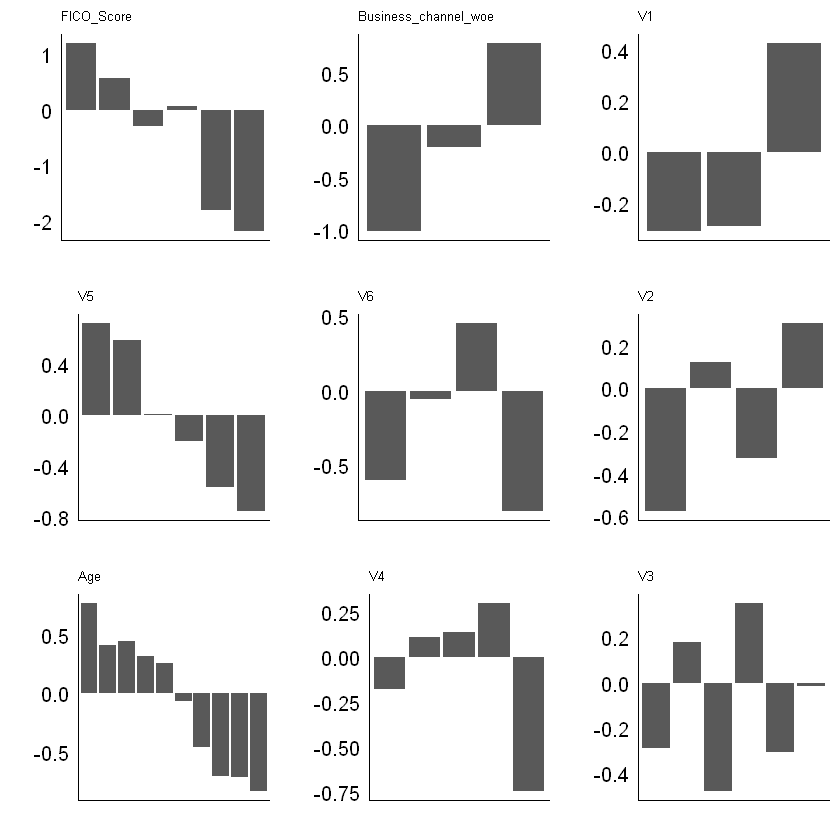

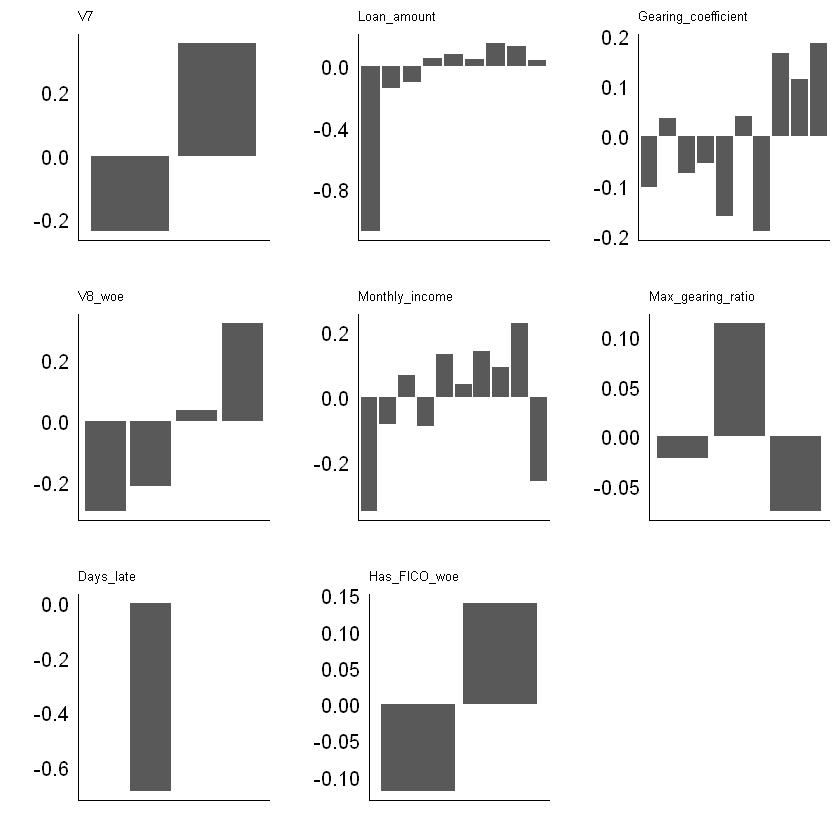

In [36]:
MultiPlot(IV, IV$Summary$Variable[1:17])

We will keep the top 10 variables for modeling:

In [139]:
predictors_selected <- c('ID', 'FICO_Score', 'V5', 'Age', 'Business_channel_woe', 'V6', 'V4', 'V1','V2','V3', 'V7')

In [62]:
train_processed <- train[, c('ID', 'FICO_Score', 'V5', 'Age', 'Business_channel_woe', 'V6', 'V4', 'V1','V2','V3', 'V7','Default_45')]

In [63]:
head(train_processed)

ID,FICO_Score,V5,Age,Business_channel_woe,V6,V4,V1,V2,V3,V7,Default_45
250263,-0.08325627,0.99310611,1.7810399,-1.3490941,1.5461945,1.2366172,-0.8043865,-2.0644126,0.5260518,-0.789633,0
249516,-0.08325627,-0.97091270,0.9574122,-1.3490941,-0.6298075,0.5021967,1.0264693,-0.4098381,0.2574662,-0.789633,1
249827,-0.08325627,0.01109671,-0.3903424,-1.3490941,-0.6298075,-0.9666443,-0.8043865,-0.4098381,-1.0854620,-0.789633,0
250375,-0.08325627,-1.46191740,1.4066637,-1.3490941,1.5461945,1.2366172,0.1110414,1.2447364,0.5260518,-0.789633,1
250334,-0.08325627,-0.47990799,-0.3154671,-1.3490941,-0.6298075,0.5021967,-0.8043865,-0.4098381,1.6003944,-0.789633,1
250033,-0.08325627,-0.97091270,-1.4385959,-0.4066313,-0.6298075,0.5021967,1.0264693,-0.4098381,-1.6226333,1.296033,0


In [42]:
test_processed <- test[ , c('ID', 'FICO_Score', 'V5', 'Age', 'Business_channel_woe', 'V6', 'V4', 'V1','V2','V3', 'V7','Default_45')]

In [40]:
head(test_processed)

ID,FICO_Score,V5,Age,Business_channel_woe,V6,V4,V1,V2,V3,V7,Default_45
250290,1.49818259,0.50210141,1.1071627,-1.3490941,-2.80580961,0.5021967,-0.8043865,-1.2371253,-0.8168764,-0.789633,0
250249,-0.24173064,1.48411081,1.4066637,-1.3490941,1.54619454,1.2366172,0.1110414,-0.4098381,0.5260518,-0.789633,0
250329,-0.08325627,0.50210141,-0.3903424,-0.4066313,-0.62980753,-0.9666443,-0.8043865,-0.4098381,0.5260518,1.296033,0
250196,0.59094212,1.48411081,1.2569132,-1.3490941,1.54619454,1.2366172,0.1110414,0.4174491,0.5260518,1.296033,0
250358,-0.08325627,-0.47990799,-0.4652176,-0.4066313,0.09552649,-0.2322238,-0.8043865,-0.4098381,0.7946375,-0.789633,0
250415,-0.08325627,0.01109671,-0.3154671,-1.3490941,-0.62980753,-1.7010648,1.0264693,-0.4098381,1.3318087,1.296033,0


### 4. Model Fitting & Interpreting Results

### 4.1 Logistic regression

#### First, fit logistic regression will variables selected by IV information

In [43]:
LR_IV <- glm(Default_45 ~ ., data = train_processed[, -1], family = binomial)
summary(LR_IV)


Call:
glm(formula = Default_45 ~ ., family = binomial, data = train_processed[, 
    -1])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6530  -0.7418  -0.4907  -0.1425   3.1273  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.33534    0.08733  -3.840 0.000123 ***
FICO_Score           -0.78284    0.05513 -14.199  < 2e-16 ***
V5                   -0.42688    0.04960  -8.606  < 2e-16 ***
Age                  -0.24647    0.05115  -4.818 1.45e-06 ***
Business_channel_woe  0.95690    0.07076  13.524  < 2e-16 ***
V6                    0.26000    0.05272   4.932 8.14e-07 ***
V4                    0.16999    0.04092   4.155 3.26e-05 ***
V1                    0.15714    0.03419   4.596 4.31e-06 ***
V2                    0.20829    0.03801   5.479 4.27e-08 ***
V3                    0.03011    0.03327   0.905 0.365494    
V7                    0.03424    0.03878   0.883 0.377180    
---
Signif. codes:  0 '***' 0.001 '*

We can see all the variables selected by IV information above 0.9 are significant.     
Then we will retrain the logistic regression model with the significant predictors.

In [44]:
lr_2 <- glm(Default_45 ~ FICO_Score + V5 + Age + Business_channel_woe + V6 + V4 + V1 + V2, 
            data = train_processed[, -1], family = binomial)
summary(lr_2)


Call:
glm(formula = Default_45 ~ FICO_Score + V5 + Age + Business_channel_woe + 
    V6 + V4 + V1 + V2, family = binomial, data = train_processed[, 
    -1])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6442  -0.7425  -0.4901  -0.1436   3.1105  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.34571    0.08647  -3.998 6.39e-05 ***
FICO_Score           -0.78290    0.05512 -14.203  < 2e-16 ***
V5                   -0.42587    0.04955  -8.596  < 2e-16 ***
Age                  -0.26308    0.04768  -5.517 3.45e-08 ***
Business_channel_woe  0.94769    0.06993  13.552  < 2e-16 ***
V6                    0.26583    0.05249   5.064 4.10e-07 ***
V4                    0.17349    0.04056   4.277 1.89e-05 ***
V1                    0.16398    0.03333   4.920 8.67e-07 ***
V2                    0.21009    0.03798   5.531 3.18e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter fo

We can see the selected predictors are all siginificant. Then we can make prediction and measure its accuracy with ROC and auc.

In [45]:
# Make prediction on test data with the retrain lr model
test_processed$lr_prob <- predict(lr_2,type='response',newdata= test_processed[, -1])
lr_pred <- prediction(test_processed$lr_prob, test_processed$Default_45)
lr_perf <- performance(lr_pred,"tpr","fpr")

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.7769

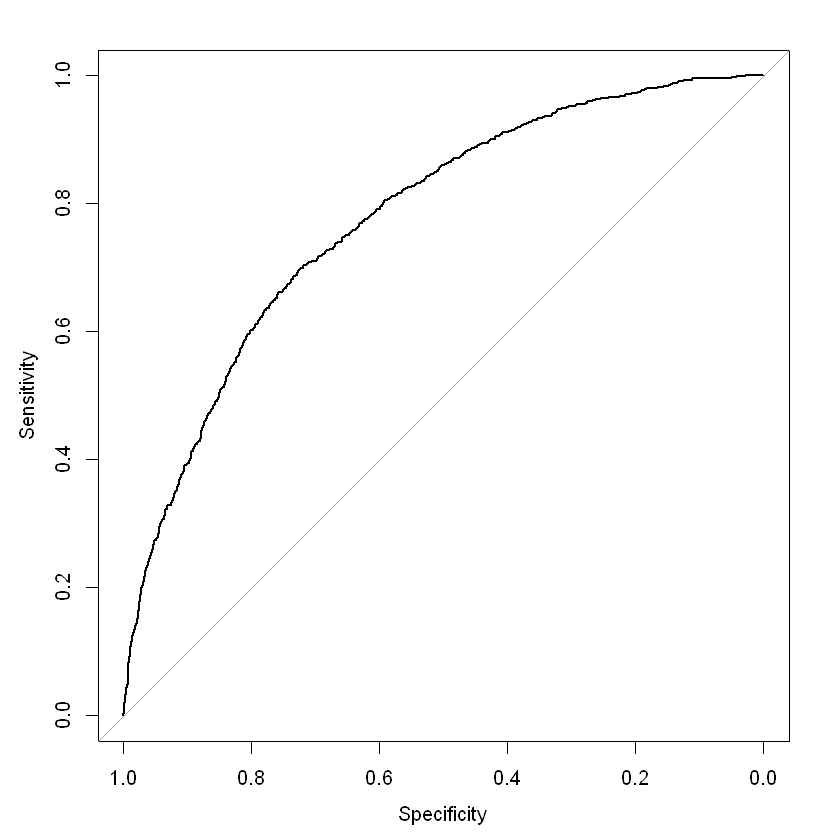

In [46]:
# plot ROC
g <- roc(Default_45 ~ lr_prob, data = test_processed)
plot(g)
auc(g)

### 4.2 Random Forest

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

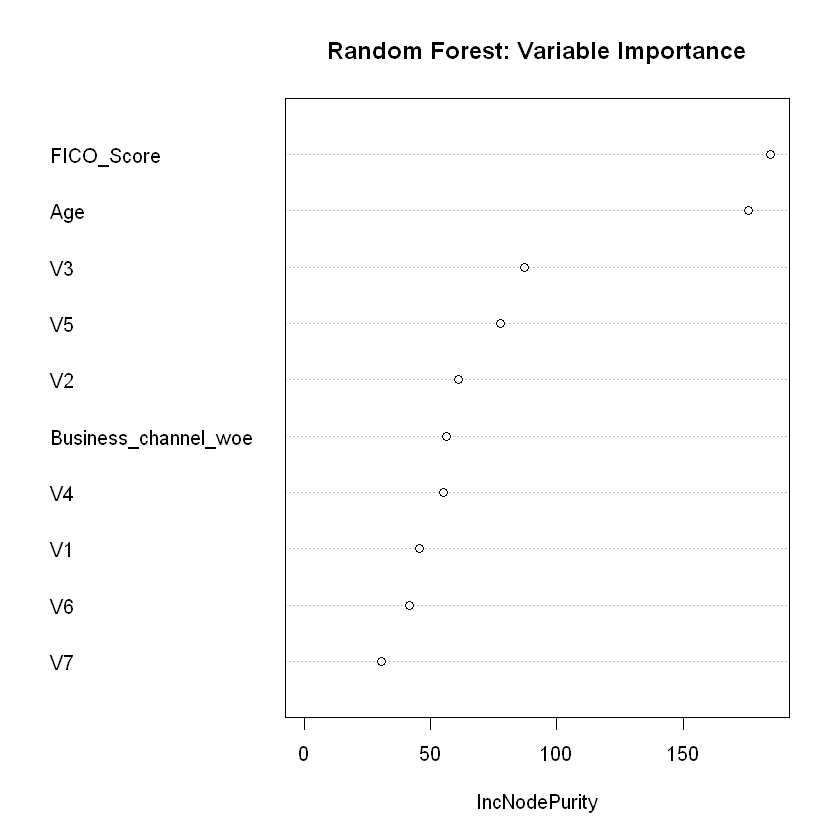

In [44]:
rf <- randomForest(Default_45 ~ ., data = train_processed[, -1])

fit_rf <- predict(rf, newdata = test_processed[, -1], type="response")
pred_rf <- prediction(fit_rf, test_processed$Default_45)
rf_perf <- performance(pred_rf, "tpr", "fpr")

#plot variable importance
varImpPlot(rf, main="Random Forest: Variable Importance")

We can see predictor V3 become the 3rd important variable in the random forest model.

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.7575

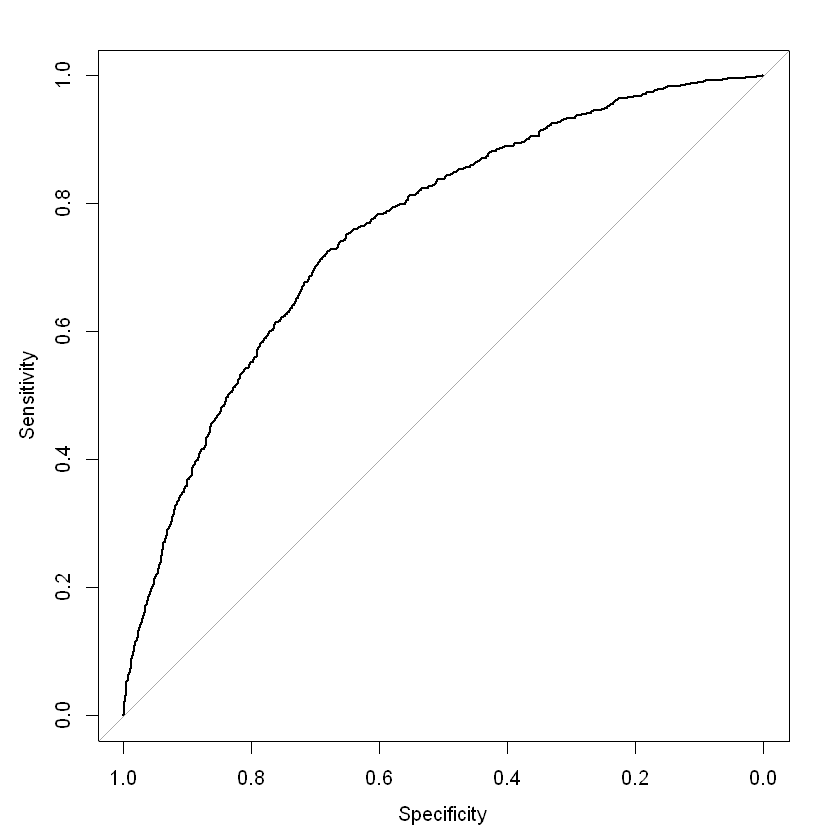

In [79]:
test_processed$rf_prob <- fit_rf
g <- roc(Default_45 ~ rf_prob, data = test_processed)
plot(g)
auc(g)

### 4.3 Recursive partitioning for classification

In [88]:
rp <- rpart(Default_45 ~ ., data = train_processed[, -1])
printcp(rp)


Regression tree:
rpart(formula = Default_45 ~ ., data = train_processed[, -1])

Variables actually used in tree construction:
[1] Age                  Business_channel_woe FICO_Score          
[4] V5                  

Root node error: 1100.1/6000 = 0.18335

n= 6000 

        CP nsplit rel error  xerror     xstd
1 0.059554      0   1.00000 1.00023 0.015571
2 0.034083      1   0.94045 0.94638 0.014450
3 0.020840      2   0.90636 0.91600 0.014747
4 0.014893      3   0.88552 0.89301 0.014743
5 0.012391      4   0.87063 0.88634 0.014691
6 0.010000      5   0.85824 0.87167 0.014742


We can see from the information about the method, only Age,  Business_channel_woe, FICO_Score and V5 used.   
Then we can plot the tree:

Warning message:
"Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call prp with roundint=FALSE,
    or rebuild the rpart model with model=TRUE."

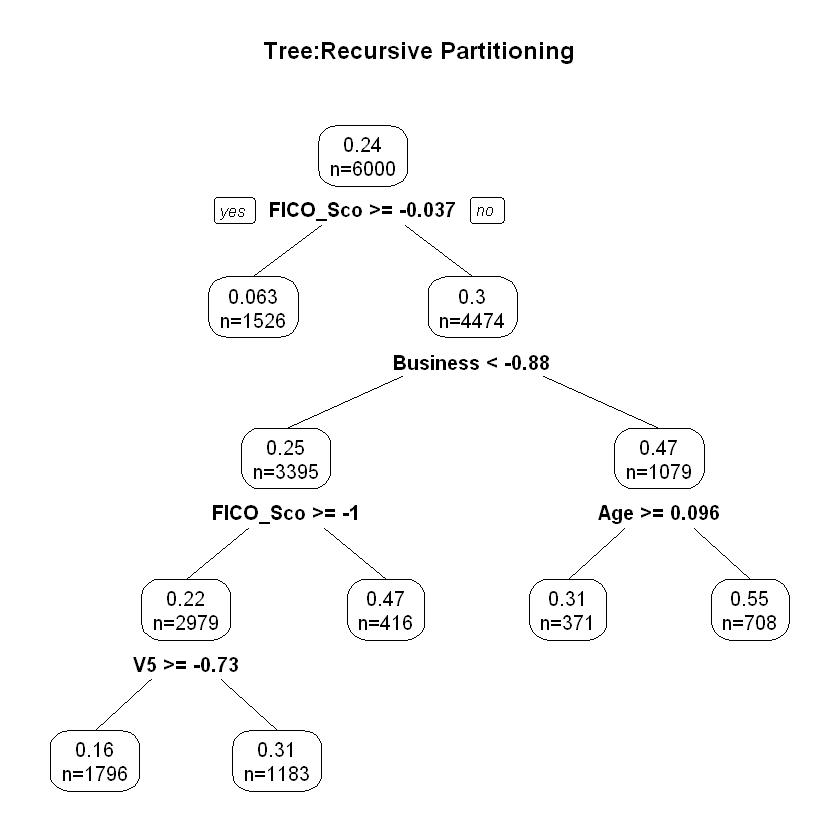

In [92]:
prp(rp, type=2, extra=1, main="Tree:Recursive Partitioning")

We can see from the graph that how the predictor work in this model.

In [95]:
# make prediction on test data and check the performance
test_processed$rp_prob <- predict(rp, newdata = test_processed[, -1])
rp_pred <- prediction(test_processed$rp_prob, test_processed$Default_45)
rp_perf <- performance(rp_pred,"tpr","fpr")

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.7299

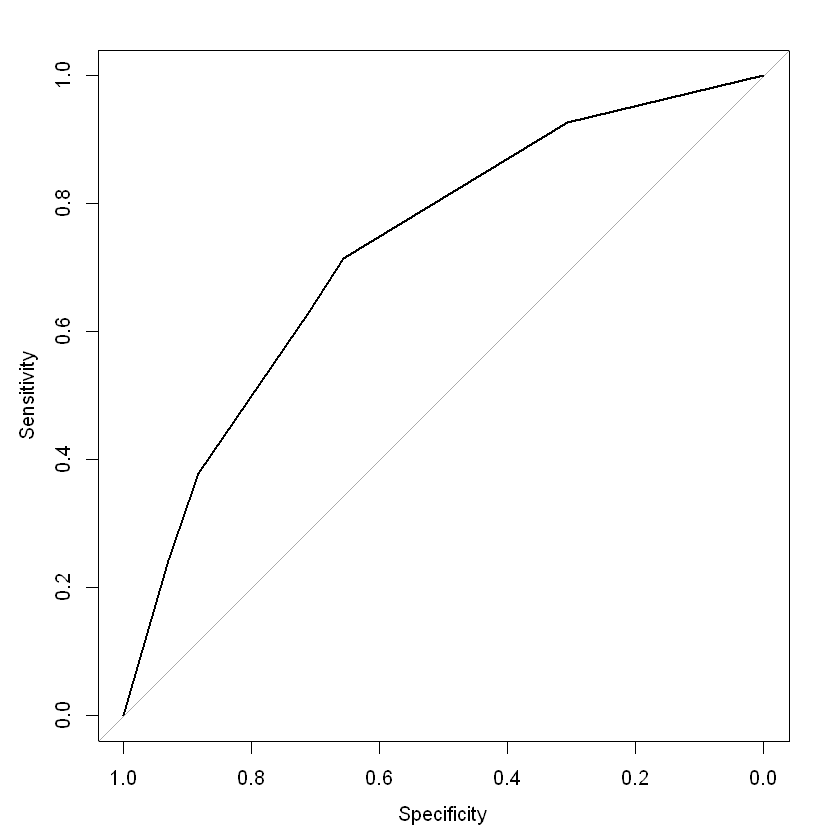

In [96]:
g <- roc(Default_45 ~ rp_prob, data = test_processed)
plot(g)
auc(g)

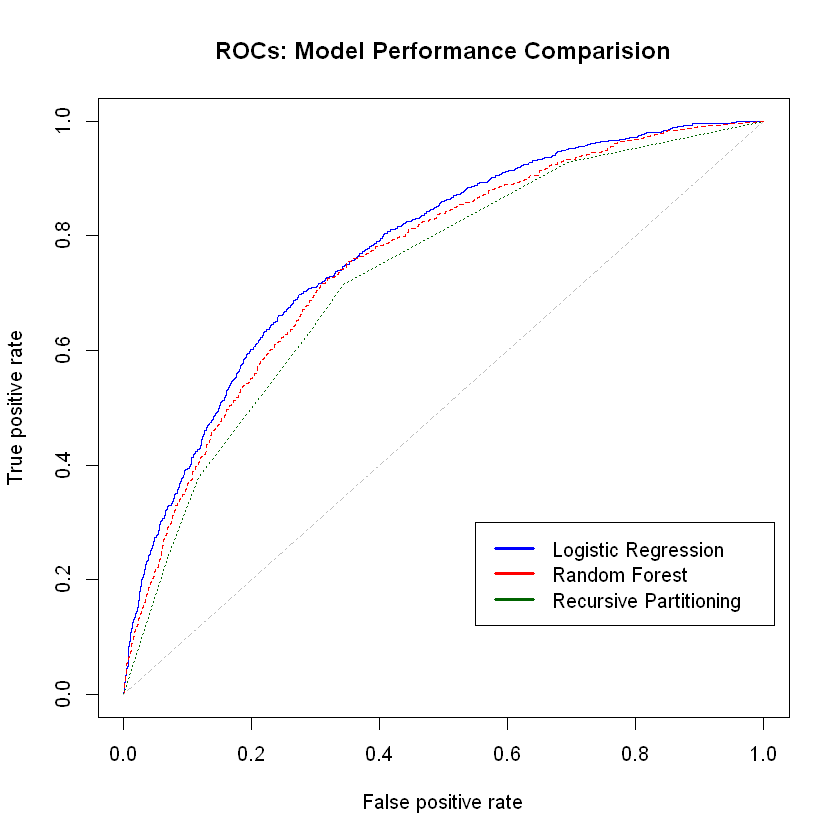

In [106]:
 # logistic regression
plot(lr_perf, col='blue', lty=1, main='ROCs: Model Performance Comparision')
# random forest
plot(rf_perf, col='red',lty=2, add=TRUE);
# recursive partitioning
plot(rp_perf, col='dark green',lty=3, add=TRUE);
# legend
legend(0.55,0.3,
           c('Logistic Regression','Random Forest','Recursive Partitioning'),
           col=c('blue','red', 'dark green'),
           lwd=3);
# random line
lines(c(0,1),c(0,1),col = "gray", lty = 4 )

We can see that among the 3 models, the ROC curve are pretty similar.    
But still Logistic Regression got the best accuracy among the three models.   
Then we will use the reult of Logistic Regression to make the application scorecard.

### 5.  Application Scorecard

#### 5.1 Calculate scorecard scores for variables based on the results from woebin and glm

In [127]:
# Calculate scorecard scores for variables based on the results from woebin and glm: 
bins_var <- woebin(train_processed, y = "Default_45", no_cores = 20, positive = "Default_45|1")
my_card <- scorecard(bins_var, lr_2, points0 = 600, odds0 = 1/19, pdo = 20)

my_card

[INFO] creating woe binning ... 
[INFO] Binning on 6000 rows and 12 columns in 00:00:10 


$basepoints
     variable bin woe points
1: basepoints  NA  NA    525

$FICO_Score
     variable          bin count count_distr good bad    badprob         woe
1: FICO_Score  [-Inf,-0.7)  1065  0.17750000  574 491 0.46103286  0.98646919
2: FICO_Score [-0.7,-0.05)  3400  0.56666667 2538 862 0.25352941  0.06277808
3: FICO_Score  [-0.05,0.3)   350  0.05833333  300  50 0.14285714 -0.64910501
4: FICO_Score   [0.3, Inf)  1185  0.19750000 1137  48 0.04050633 -2.02229303
        bin_iv  total_iv breaks is_special_values points
1: 0.209334424 0.6706072   -0.7             FALSE     22
2: 0.002269317 0.6706072  -0.05             FALSE      1
3: 0.020440035 0.6706072    0.3             FALSE    -15
4: 0.438563382 0.6706072    Inf             FALSE    -46

$V5
   variable                           bin count count_distr good bad   badprob
1:       V5          [-Inf,-0.4799079948)  1896   0.3160000 1184 712 0.3755274
2:       V5 [-0.4799079948,0.01109670624)  1018   0.1696667  770 248 0.2436149
3:       V5  [0.01109670624,0.9931061083)  1351   0.2251667 1086 265 0.1961510
4:       V5           [0.9931061083, Inf)  1735   0.2891667 1509 226 0.1302594
            woe       bin_iv  total_iv        breaks is_special_values points
1:  0.634078551 1.461038e-01 0.2941808 -0.4799079948             FALSE      8
2:  0.009692686 1.597973e-05 0.2941808 0.01109670624             FALSE      0
3: -0.267872220 1.502793e-02 0.2941808  0.9931061083             FALSE     -3
4: -0.756013005 1.330330e-01 0.2941808           Inf             FALSE     -9

$Age
   variable       bin count count_distr good bad   badprob        woe
1:      Age [-Inf,-1)  1237   0.2061667  775 462 0.3734842  0.6253563
2:      Age    [-1,0)  2096   0.3493333 1486 610 0.2910305  0.2522702
3:      Age  [0, Inf)  2667   0.4445000 2288 379 0.1421072 -0.6552427
       bin_iv  total_iv breaks is_special_values points
1: 0.09257399 0.2746375     -1             FALSE      5
2: 0.02364643 0.2746375      0             FALSE      2
3: 0.15841705 0.2746375    Inf             FALSE     -5

$Business_channel
Empty data.table (0 rows and 13 cols): variable,bin,count,count_distr,good,bad...

$V6
   variable                           bin count count_distr good bad   badprob
1:       V6          [-Inf,-0.6298075341)   517  0.08616667  440  77 0.1489362
2:       V6 [-0.6298075341,0.09552649112)  1908  0.31800000 1467 441 0.2311321
3:       V6   [0.09552649112,1.546194541)  2326  0.38766667 1548 778 0.3344798
4:       V6            [1.546194541, Inf)  1249  0.20816667 1094 155 0.1240993
           woe     bin_iv  total_iv        breaks is_special_values points
1: -0.60031485 0.02620837 0.2248461 -0.6298075341             FALSE      5
2: -0.05927545 0.00110016 0.2248461 0.09552649112             FALSE      0
3:  0.45466192 0.08906253 0.2248461   1.546194541             FALSE     -3
4: -0.81151641 0.10847502 0.2248461           Inf             FALSE      6

$V4
   variable                         bin count count_distr good bad   badprob
1:       V4        [-Inf,-0.9666442565)   819   0.1365000  647 172 0.2100122
2:       V4 [-0.9666442565,0.502196735)  1764   0.2940000 1298 466 0.2641723
3:       V4   [0.502196735,1.236617231)  2155   0.3591667 1508 647 0.3002320
4:       V4          [1.236617231, Inf)  1262   0.2103333 1096 166 0.1315372
          woe      bin_iv  total_iv        breaks is_special_values points
1: -0.1821974 0.004316278 0.1367027 -0.9666442565             FALSE      1
2:  0.1182602 0.004236126 0.1367027   0.502196735             FALSE     -1
3:  0.2964612 0.033914554 0.1367027   1.236617231             FALSE     -1
4: -0.7447802 0.094235711 0.1367027           Inf             FALSE      4

$V1
   variable                       bin count count_distr good bad   badprob
1:       V1        [-Inf,1.026469325)  3749  0.62483333 3037 712 0.1899173
2:       V1 [1.026469325,1.941897243)  1734  0.28900000 1129 605 0.3489043
3:       V1        [1.941897243, Inf)   517  0.08616667  383 134 0.2591876
 

In [128]:
do.call("bind_rows", my_card) %>% 
  mutate_if(is.numeric, function(x) {round(x, 3)}) %>% 
  mutate(bin = bin %>% 
           str_replace_all("\\[", "From ") %>% 
           str_replace_all("\\,", " to ") %>% 
           str_replace_all("\\)", "")) -> iv_for_predictors_point

iv_for_predictors_point <- iv_for_predictors_point[-1, c("variable", "bin", "woe", "points", "bin_iv", "total_iv")]
head(iv_for_predictors_point)

,variable,bin,woe,points,bin_iv,total_iv
2,FICO_Score,From -Inf to -0.7,0.986,22,0.209,0.671
3,FICO_Score,From -0.7 to -0.05,0.063,1,0.002,0.671
4,FICO_Score,From -0.05 to 0.3,-0.649,-15,0.020,0.671
5,FICO_Score,From 0.3 to Inf,-2.022,-46,0.439,0.671
6,V5,From -Inf to -0.4799079948,0.634,8,0.146,0.294
7,V5,From -0.4799079948 to 0.01109670624,0.010,0,0.000,0.294


In [129]:
iv_for_predictors_point %>% 
  knitr::kable(col.names = c("Predictor", "Group", "WOE", "Scorecard", "Bin IV", "Total IV"))



|   |Predictor  |Group                               |    WOE| Scorecard| Bin IV| Total IV|
|:--|:----------|:-----------------------------------|------:|---------:|------:|--------:|
|2  |FICO_Score |From -Inf to -0.7                   |  0.986|        22|  0.209|    0.671|
|3  |FICO_Score |From -0.7 to -0.05                  |  0.063|         1|  0.002|    0.671|
|4  |FICO_Score |From -0.05 to 0.3                   | -0.649|       -15|  0.020|    0.671|
|5  |FICO_Score |From 0.3 to  Inf                    | -2.022|       -46|  0.439|    0.671|
|6  |V5         |From -Inf to -0.4799079948          |  0.634|         8|  0.146|    0.294|
|7  |V5         |From -0.4799079948 to 0.01109670624 |  0.010|         0|  0.000|    0.294|
|8  |V5         |From 0.01109670624 to 0.9931061083  | -0.268|        -3|  0.015|    0.294|
|9  |V5         |From 0.9931061083 to  Inf           | -0.756|        -9|  0.133|    0.294|
|10 |Age        |From -Inf to -1                     |  0.625|         5|  0.0

#### 5.2 Check scorecard point for all observations

#### train data

In [130]:
# Scorecard point for all observations from train data set: 
my_points_train <- scorecard_ply(train_processed, my_card, only_total_score = FALSE, print_step = 0) %>% as.data.frame()

# Some statistics scorecard by group: 
df_scored_train <- train_processed %>% 
  mutate(SCORE = my_points_train$score) %>% 
  mutate(Default_45 = case_when(Default_45 == 1 ~ "Default", TRUE ~ "NonDefault")) 

df_scored_train %>% 
  group_by(Default_45) %>% 
  summarise_each(funs(min, max, median, mean, n()), SCORE) %>% 
  mutate_if(is.numeric, function(x) {round(x, 0)}) %>% 
  knitr::kable(caption = "Scorecad Points by Group for Train Data")



|Default_45 | min| max| median| mean|    n|
|:----------|---:|---:|------:|----:|----:|
|Default    | 468| 570|    537|  536| 1451|
|NonDefault | 468| 568|    523|  517| 4549|

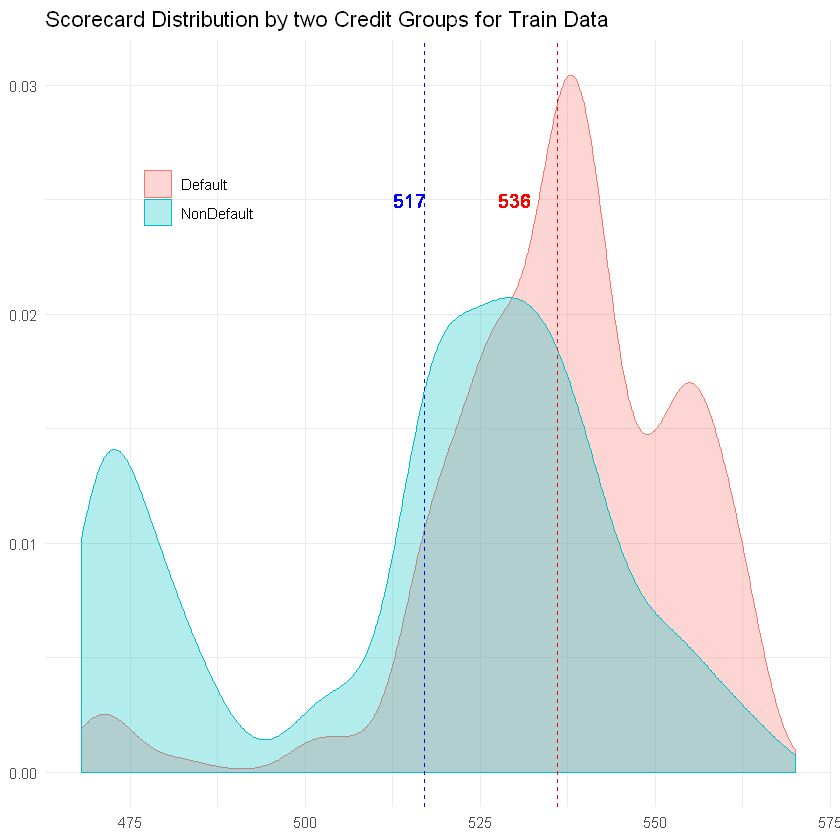

In [133]:
df_scored_train %>% 
     group_by(Default_45) %>% 
     summarise(tb = mean(SCORE)) %>% 
     ungroup() -> mean_score_train

df_scored_train  %>% 
  ggplot(aes(SCORE, color = Default_45, fill = Default_45)) + 
  geom_density(alpha = 0.3) + 
  geom_vline(aes(xintercept = 536), linetype = "dashed", color = "red") + 
  geom_vline(aes(xintercept = 517), linetype = "dashed", color = "blue") + 
  geom_text(aes(x = (530), y = 0.025, label = 536 %>% round(0)), color = "red", size = 4) + 
  geom_text(aes(x = 515, y = 0.025, label = 517 %>% round(0)), color = "blue", size = 4) + 
  theme(legend.title = element_blank()) + 
  theme(legend.position = c(0.2, 0.8)) + 
  labs(x = NULL, y = NULL, title = "Scorecard Distribution by two Credit Groups for Train Data")

####  Test data

In [145]:
bins_var <- woebin(test_processed, y = "Default_45", no_cores = 20, positive = "Default_45|1")
my_card_t <- scorecard(bins_var, lr_2, points0 = 600, odds0 = 1/19, pdo = 20)

# Scorecard Points for test data set: 
my_points_test <- scorecard_ply(test_processed, my_card_t, print_step = 0, 
                                only_total_score = FALSE) %>% as.data.frame()


df_scored_test <- test_processed %>% 
  mutate(SCORE = my_points_test$score) %>% 
  mutate(Default_45 = case_when(Default_45 == 1 ~ "Default", TRUE ~ "NonDefault")) 

df_scored_test %>% 
  group_by(Default_45) %>% 
  summarise_each(funs(min, max, median, mean, n()), SCORE) %>% 
  mutate_if(is.numeric, function(x) {round(x, 0)}) %>% 
  knitr::kable(caption = " Scorecad Points by Group for Test Data")

[INFO] creating woe binning ... 
[INFO] Binning on 4000 rows and 13 columns in 00:00:10 




|Default_45 | min| max| median| mean|    n|
|:----------|---:|---:|------:|----:|----:|
|Default    | 464| 572|    539|  538|  913|
|NonDefault | 456| 573|    522|  518| 3087|

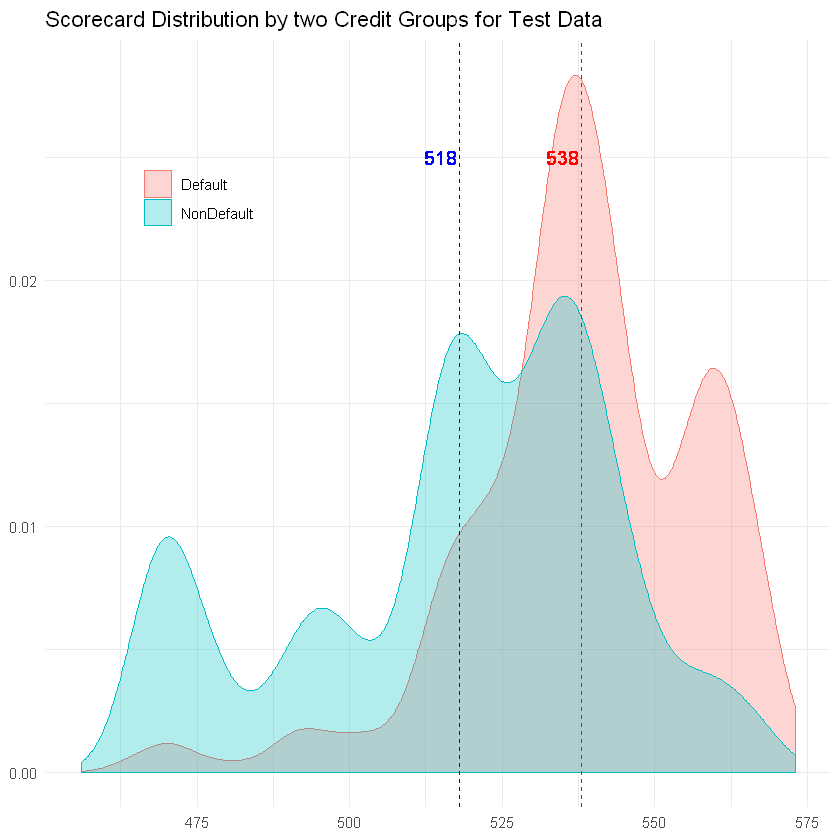

In [148]:
df_scored_test %>% 
  group_by(Default_45) %>% 
  summarise(tb = mean(SCORE)) %>% 
  ungroup() -> mean_score_test

df_scored_test %>% 
  ggplot(aes(SCORE, color = Default_45, fill = Default_45)) + 
  geom_density(alpha = 0.3) + 
  geom_vline(aes(xintercept = 538), linetype = "dashed", color = "red") + 
  geom_vline(aes(xintercept = 518), linetype = "dashed", color = "blue") + 
  geom_text(aes(x = 535, y = 0.025, label = 538 %>% round(0)), color = "red", size = 4) + 
  geom_text(aes(x = 515, y = 0.025, label = 518 %>% round(0)), color = "blue", size = 4) + 
  theme(legend.title = element_blank()) + 
  theme(legend.position = c(0.2, 0.8)) + 
  labs(x = NULL, y = NULL, title = "Scorecard Distribution by two Credit Groups for Test Data")

The means between train and test data of the Default and NoDefualt are very similar.

#### 5.3 Finalize scorecard

In [134]:
row.names(iv_for_predictors_point) <- NULL

In [135]:
iv_for_predictors_point <- iv_for_predictors_point[, c("variable", "bin", "points")]

names(iv_for_predictors_point)[1] <- "Characteristic"
names(iv_for_predictors_point)[2] <- "Attribute"
names(iv_for_predictors_point)[3] <- "Scorecard Points"


iv_for_predictors_point

Characteristic,Attribute,Scorecard Points
FICO_Score,From -Inf to -0.7,22
FICO_Score,From -0.7 to -0.05,1
FICO_Score,From -0.05 to 0.3,-15
FICO_Score,From 0.3 to Inf,-46
V5,From -Inf to -0.4799079948,8
V5,From -0.4799079948 to 0.01109670624,0
V5,From 0.01109670624 to 0.9931061083,-3
V5,From 0.9931061083 to Inf,-9
Age,From -Inf to -1,5
Age,From -1 to 0,2


#### 5.4 Evaluate probabilities of default (PD)

In [149]:
# Cteate a data frame of PD: 
test_processed %>% 
  mutate(prob_default = lr_prob, 
         Default_45 = case_when(Default_45 == 1 ~ "Default", TRUE ~ "NonDefault")) -> prob_default_df 

# Show some statistics: 

prob_default_df %>% 
  group_by(Default_45) %>% 
  summarise_each(funs(min, max, median, mean, n()), prob_default) %>% 
  mutate_if(is.numeric, function(x) {round(x, 4)}) %>% 
  knitr::kable(caption = "Probabilities of Default by Group for Test Data")



|Default_45 |    min|    max| median|   mean|    n|
|:----------|------:|------:|------:|------:|----:|
|Default    | 0.0172| 0.9087| 0.3429| 0.3672|  913|
|NonDefault | 0.0043| 0.8607| 0.1628| 0.1952| 3087|

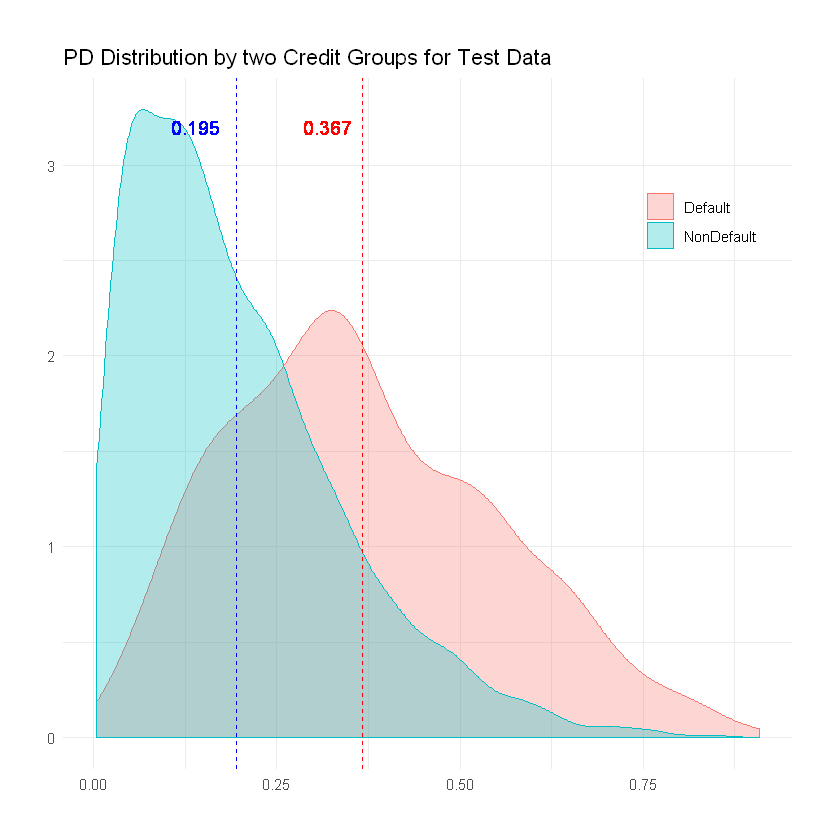

In [153]:
prob_default_df %>% 
  group_by(Default_45) %>% 
  summarise(tb = mean(prob_default)) %>% 
  ungroup() -> mean_prob_test

prob_default_df %>% 
  ggplot(aes(prob_default, color = Default_45, fill = Default_45)) + 
  geom_density(alpha = 0.3) + 
  geom_vline(aes(xintercept = 0.367), linetype = "dashed", color = "red") + 
  geom_vline(aes(xintercept = 0.195), linetype = "dashed", color = "blue") + 
  geom_text(aes(x = 0.32, y = 3.2, label = 0.367 %>% round(4)), color = "red", size = 4) + 
  geom_text(aes(x = 0.14, y = 3.2, label = 0.195 %>% round(4)), color = "blue", size = 4) + 
  theme(legend.title = element_blank()) + 
  theme(legend.position = c(0.88, 0.8)) + 
  theme(plot.margin = unit(c(1, 1, 1, 1), "cm")) + 
  labs(x = NULL, y = NULL, title = "PD Distribution by two Credit Groups for Test Data")

### 6.LGD

#### Read in data

In [180]:
lgd1 <- read.csv("lgd.csv", header=TRUE)
head(lgd1)

LTV,Recovery_rate,lgd_time,y_logistic,lnrr,Y_probit,purpose1,event
0.21407810,0.6980155,0.30198448,-0.8378657,-0.359513940,-0.5187014,0,1
0.21407810,0.7800841,0.21991590,-1.2661566,-0.248353538,-0.7724773,0,1
0.21407810,0.7022869,0.29771308,-0.8582118,-0.353413236,-0.5309894,0,1
0.21407810,0.7539889,0.24601110,-1.1200010,-0.282377634,-0.6870961,0,1
0.21407810,0.8028126,0.19718739,-1.4039668,-0.219633958,-0.8517105,0,1
0.02738354,0.9921424,0.00785762,-4.8383828,-0.007888654,-2.4154625,0,1


In [186]:
dim(lgd1)

[1] 2545    8

#### look into data sturcture and summary

In [181]:
str(lgd1)

'data.frame':	2545 obs. of  8 variables:
 $ LTV          : num  0.214 0.214 0.214 0.214 0.214 ...
 $ Recovery_rate: num  0.698 0.78 0.702 0.754 0.803 ...
 $ lgd_time     : num  0.302 0.22 0.298 0.246 0.197 ...
 $ y_logistic   : num  -0.838 -1.266 -0.858 -1.12 -1.404 ...
 $ lnrr         : num  -0.36 -0.248 -0.353 -0.282 -0.22 ...
 $ Y_probit     : num  -0.519 -0.772 -0.531 -0.687 -0.852 ...
 $ purpose1     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ event        : int  1 1 1 1 1 1 0 1 1 0 ...


In [182]:
summary(lgd1)

      LTV           Recovery_rate        lgd_time         y_logistic      
 Min.   :0.001359   Min.   :0.00001   Min.   :0.00001   Min.   :-11.5129  
 1st Qu.:0.399180   1st Qu.:0.60215   1st Qu.:0.00001   1st Qu.:-11.5129  
 Median :0.659417   Median :0.96793   Median :0.03207   Median : -3.4074  
 Mean   :0.676556   Mean   :0.77187   Mean   :0.22813   Mean   : -3.9413  
 3rd Qu.:0.923548   3rd Qu.:0.99999   3rd Qu.:0.39785   3rd Qu.: -0.4144  
 Max.   :1.984065   Max.   :0.99999   Max.   :0.99999   Max.   : 11.5129  
      lnrr              Y_probit          purpose1           event       
 Min.   :-11.51292   Min.   :-4.2649   Min.   :0.00000   Min.   :0.0000  
 1st Qu.: -0.50726   1st Qu.:-4.2649   1st Qu.:0.00000   1st Qu.:0.0000  
 Median : -0.03259   Median :-1.8513   Median :0.00000   Median :1.0000  
 Mean   : -0.99665   Mean   :-1.6508   Mean   :0.07269   Mean   :0.7139  
 3rd Qu.:  0.00000   3rd Qu.:-0.2589   3rd Qu.:0.00000   3rd Qu.:1.0000  
 Max.   :  0.00000   Max.   : 4

In [194]:
# check by percentage
table(lgd1$event) / nrow(lgd1)


        0         1 
0.3151298 0.6848702 

#### check msiing values and outliners

In [184]:
sum(is.na(lgd1))

[1] 0

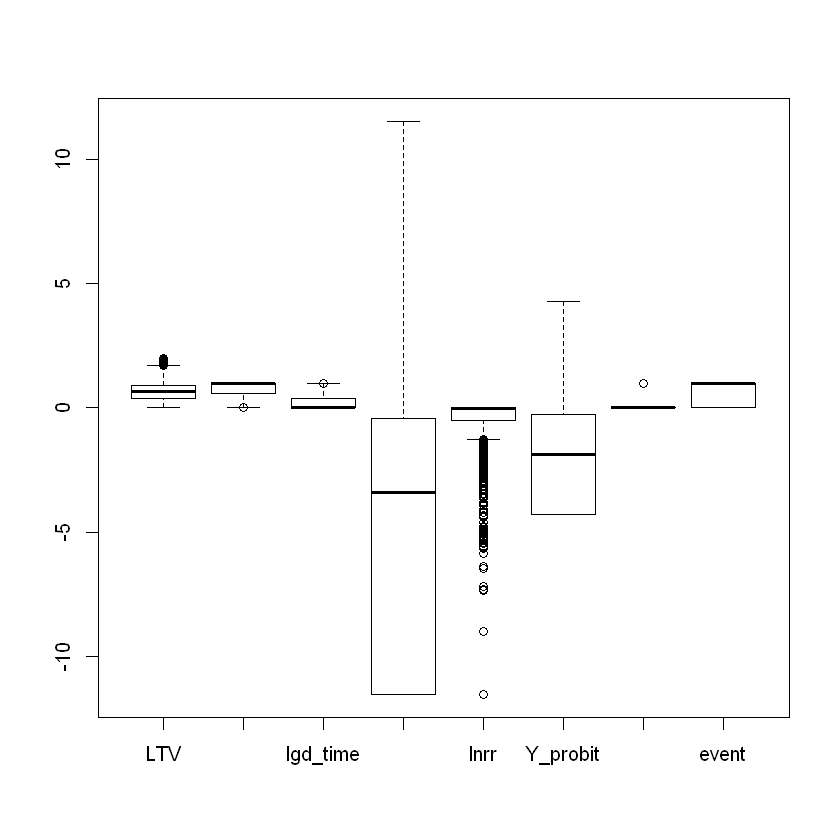

In [185]:
boxplot(lgd1)

In [187]:
# remove outliners
lgd1<-lgd1[lgd1$lnrr>-6,]
dim(lgd1)

[1] 2396    8

In [188]:
lgd1<-lgd1[!lgd1$purpose1==1,]
dim(lgd1)

[1] 2234    8

#### split data into train and test

In [191]:
splitlgd1<-createDataPartition(lgd1$event,p=0.5,list = FALSE)
train<-lgd1[splitlgd1,]
test<-lgd1[-splitlgd1,]

In [192]:
# train
ddply(train, "event", summarise, count = length(event), 
    percentage = round(length(event)/nrow(train), 2))

event,count,percentage
0,363,0.32
1,754,0.68


In [193]:
# test
ddply(test, "event", summarise, count = length(event), 
    percentage = round(length(event)/nrow(test), 2))

event,count,percentage
0,341,0.31
1,776,0.69


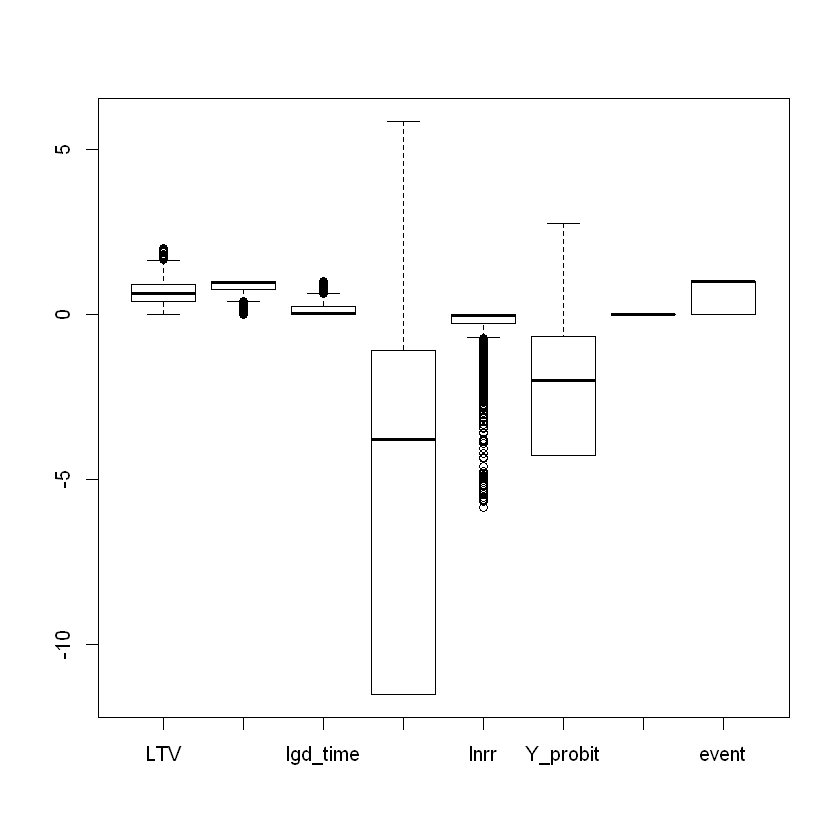

In [189]:
boxplot(lgd1)

#### Logistic Regression

In [195]:
train$event<-as.factor(train$event)
model_bin<-glm(event ~ ., data=train,family = binomial(link = "logit"))
summary(model_bin)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = event ~ ., family = binomial(link = "logit"), data = train)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-6.366e-06  -2.703e-06   2.100e-08   2.100e-08   7.310e-05  

Coefficients: (2 not defined because of singularities)
                Estimate Std. Error z value Pr(>|z|)
(Intercept)      190.959 324826.452   0.001    1.000
LTV               -2.461  33733.738   0.000    1.000
Recovery_rate   -325.215 488736.800  -0.001    0.999
lgd_time              NA         NA      NA       NA
y_logistic        82.460  43006.009   0.002    0.998
lnrr              -8.262  46332.315   0.000    1.000
Y_probit        -248.309 152172.451  -0.002    0.999
purpose1              NA         NA      NA       NA

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1.4087e+03  on 1116  degrees of freedom
Residual deviance: 1.4908e-08  on 1111  degrees of freedom
AIC: 12

Number of Fisher Scoring iterations: 25


In [196]:
pred_train_bin<-ifelse(model_bin$fitted.values>0.5,1,0)
confusionMatrix(as.factor(train$event),as.factor(pred_train_bin))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 363   0
         1   0 754
                                     
               Accuracy : 1          
                 95% CI : (0.9967, 1)
    No Information Rate : 0.675      
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.000      
            Specificity : 1.000      
         Pos Pred Value : 1.000      
         Neg Pred Value : 1.000      
             Prevalence : 0.325      
         Detection Rate : 0.325      
   Detection Prevalence : 0.325      
      Balanced Accuracy : 1.000      
                                     
       'Positive' Class : 0          
                                     

In [197]:
pr<-prediction(as.numeric(pred_train_bin),as.numeric(train$event))
auc<-performance(pr,measure = "auc")
auc<-auc@y.values
auc

[[1]]
[1] 1

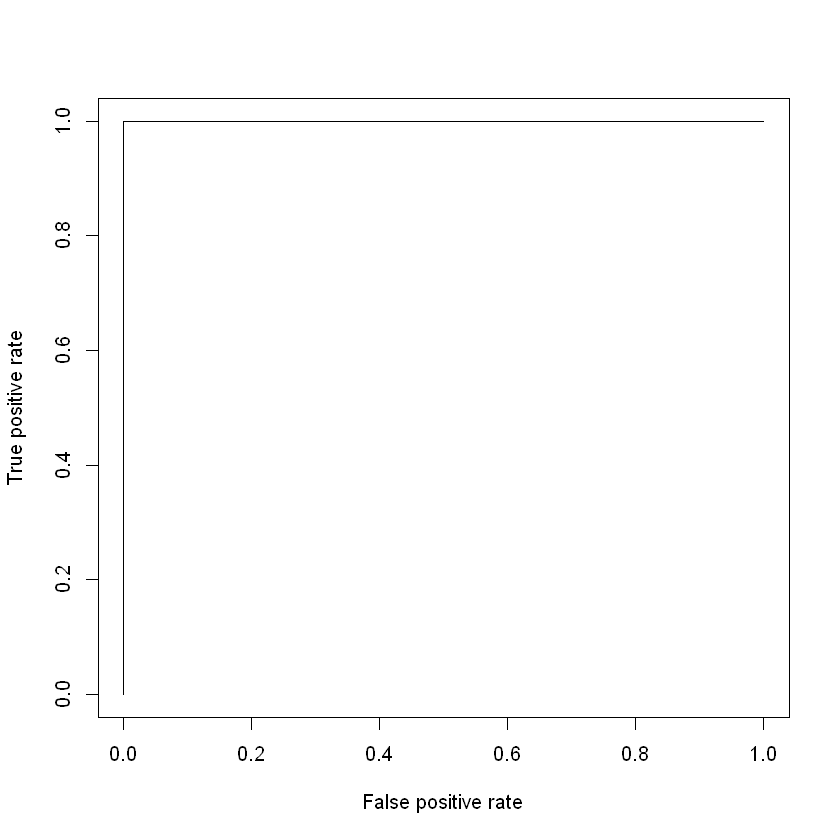

In [198]:
prf<-performance(pr,measure = "tpr",x.measure = "fpr")
plot(prf)

#### Naiv Bayes

In [205]:
metric<-"Accuracy"
model_naive<-naive_bayes(event ~ ., data=train,metric=metric)
model_naive


================================== Naive Bayes ================================== 
 
 Call: 
naive_bayes.formula(formula = event ~ ., data = train, metric = metric)

--------------------------------------------------------------------------------- 
 
Laplace smoothing: 0

--------------------------------------------------------------------------------- 
 
 A priori probabilities: 

        0         1 
0.3249776 0.6750224 

--------------------------------------------------------------------------------- 
 
 Tables: 

--------------------------------------------------------------------------------- 
 ::: LTV (Gaussian) 
--------------------------------------------------------------------------------- 
      
LTV            0         1
  mean 0.5041639 0.7362971
  sd   0.2792366 0.3538688

--------------------------------------------------------------------------------- 
 ::: Recovery_rate (Gaussian) 
--------------------------------------------------------------------------------- 
  

In [206]:
pred_train_naive<-predict(model_naive,train)
confusionMatrix(as.factor(train$event),as.factor(pred_train_naive))

Warning message:
"predict.naive_bayes(): more features in the newdata are provided as there are probability tables in the object. Calculation is performed based on features to be found in the tables."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 363   0
         1  29 725
                                          
               Accuracy : 0.974           
                 95% CI : (0.9629, 0.9825)
    No Information Rate : 0.6491          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.942           
                                          
 Mcnemar's Test P-Value : 1.999e-07       
                                          
            Sensitivity : 0.9260          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9615          
             Prevalence : 0.3509          
         Detection Rate : 0.3250          
   Detection Prevalence : 0.3250          
      Balanced Accuracy : 0.9630          
                                          
       'Positive' Class : 0               
                              

In [207]:
pr<-prediction(as.numeric(pred_train_naive),as.numeric(train$event))
auc<-performance(pr,measure = "auc")
auc<-auc@y.values
auc

[[1]]
[1] 0.9807692

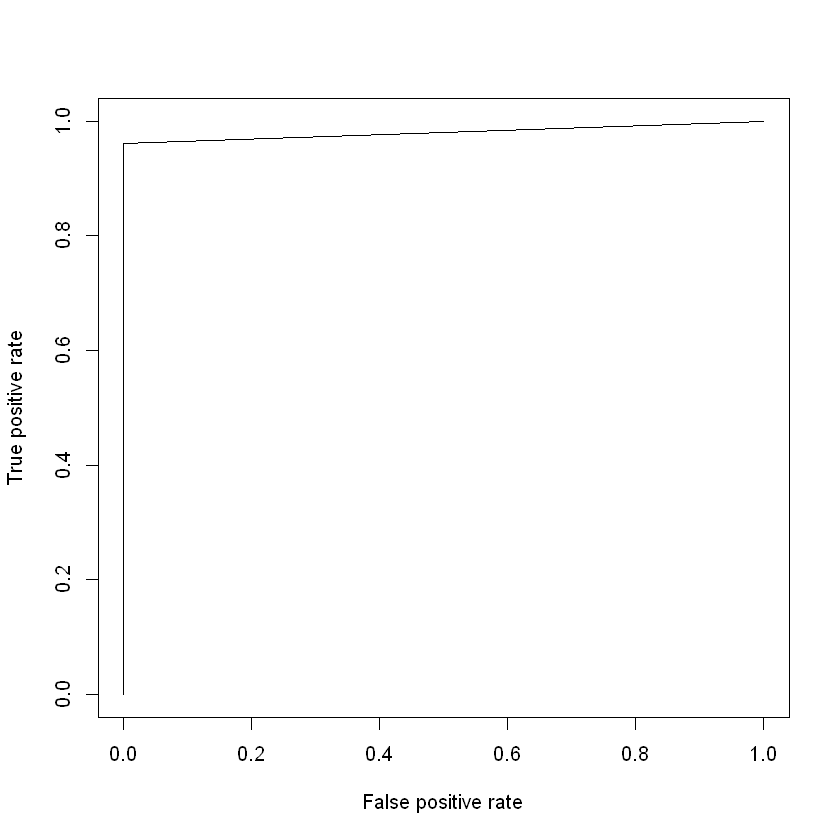

In [208]:
prf<-performance(pr,measure = "tpr",x.measure = "fpr")
plot(prf)

#### Random Forest

In [211]:
model_rforest<-randomForest(event ~ ., data=train,mtry=3,ntree=500)
model_rforest


Call:
 randomForest(formula = event ~ ., data = train, mtry = 3, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 0%
Confusion matrix:
    0   1 class.error
0 363   0           0
1   0 754           0

In [212]:
pred_train_rf<-predict(model_rforest,train)
confusionMatrix(as.factor(train$event),as.factor(pred_train_rf))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 363   0
         1   0 754
                                     
               Accuracy : 1          
                 95% CI : (0.9967, 1)
    No Information Rate : 0.675      
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.000      
            Specificity : 1.000      
         Pos Pred Value : 1.000      
         Neg Pred Value : 1.000      
             Prevalence : 0.325      
         Detection Rate : 0.325      
   Detection Prevalence : 0.325      
      Balanced Accuracy : 1.000      
                                     
       'Positive' Class : 0          
                                     

In [213]:
pr<-prediction(as.numeric(pred_train_rf),as.numeric(train$event))
auc<-performance(pr,measure = "auc")
auc<-auc@y.values
auc

[[1]]
[1] 1

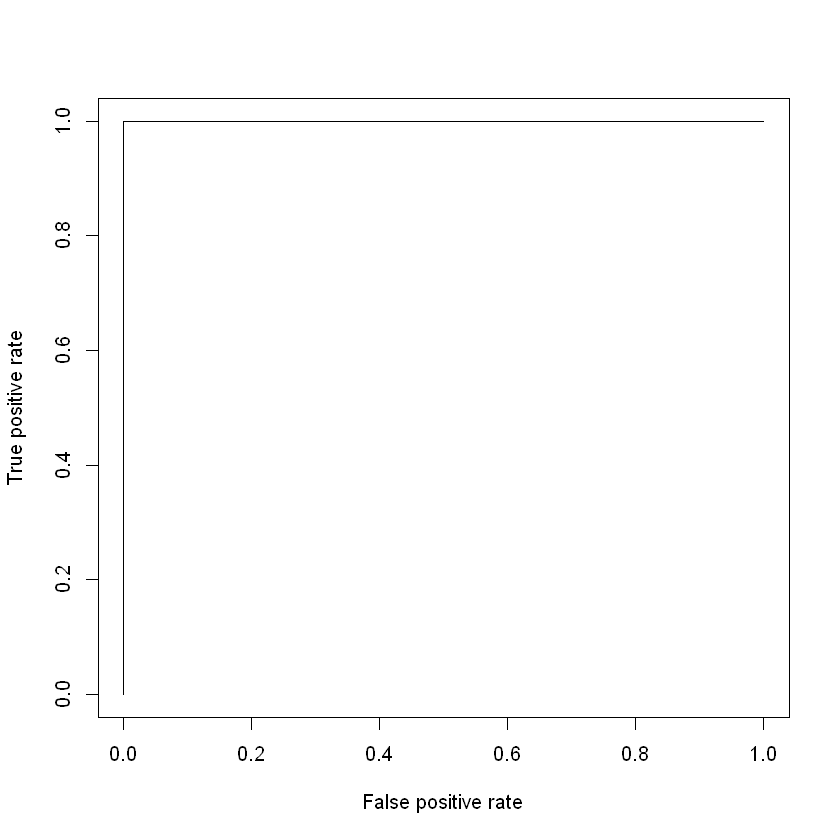

In [214]:
prf<-performance(pr,measure = "tpr",x.measure = "fpr")
plot(prf)

#### shuffle the data and split into train and test

In [217]:
set.seed(356)
splitlgd1<-createDataPartition(lgd1$event,p=0.7,list = FALSE)
train<-lgd1[splitlgd1,]
test<-lgd1[-splitlgd1,]
dim(train)

[1] 1564    8

In [218]:
splittest<-createDataPartition(test$event,p=0.6,list = FALSE)
test1<-test[splittest,]
test2<-test[-splittest,]
dim(test1)

[1] 402   8

#### Bulid the model

In [219]:
model_rforest1<-randomForest(event ~ ., data=train,mtry=5,ntree=300)
model_rforest1

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Call:
 randomForest(formula = event ~ ., data = train, mtry = 5, ntree = 300) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 5

          Mean of squared residuals: 0.0006526025
                    % Var explained: 99.7

In [220]:
pred<-predict(model_rforest1,train,type="response")
pred_train<-ifelse(pred>0.5,1,0)
confusionMatrix(as.factor(train$event),as.factor(pred_train))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  498    0
         1    0 1066
                                     
               Accuracy : 1          
                 95% CI : (0.9976, 1)
    No Information Rate : 0.6816     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.3184     
         Detection Rate : 0.3184     
   Detection Prevalence : 0.3184     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [221]:
pr<-prediction(as.numeric(pred_train),as.numeric(train$event))
auc<-performance(pr,measure = "auc")
auc<-auc@y.values
auc

[[1]]
[1] 1

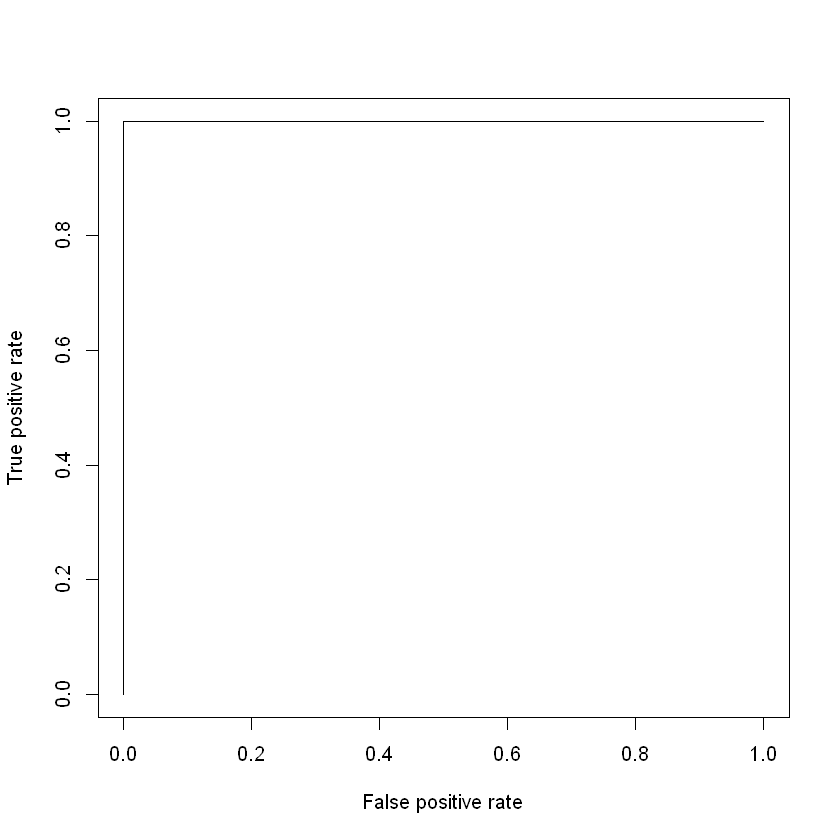

In [222]:
prf<-performance(pr,measure = "tpr",x.measure = "fpr")
plot(prf)

In [223]:
pred<-predict(model_rforest1,test1,type="response")
pred_test1<-ifelse(pred>0.5,1,0)
library(caret)
confusionMatrix(as.factor(test1$event),as.factor(pred_test1))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 132   0
         1   0 270
                                     
               Accuracy : 1          
                 95% CI : (0.9909, 1)
    No Information Rate : 0.6716     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.3284     
         Detection Rate : 0.3284     
   Detection Prevalence : 0.3284     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [224]:
pr<-prediction(as.numeric(pred_test1),as.numeric(test1$event))
auc<-performance(pr,measure = "auc")
auc<-auc@y.values
auc

[[1]]
[1] 1

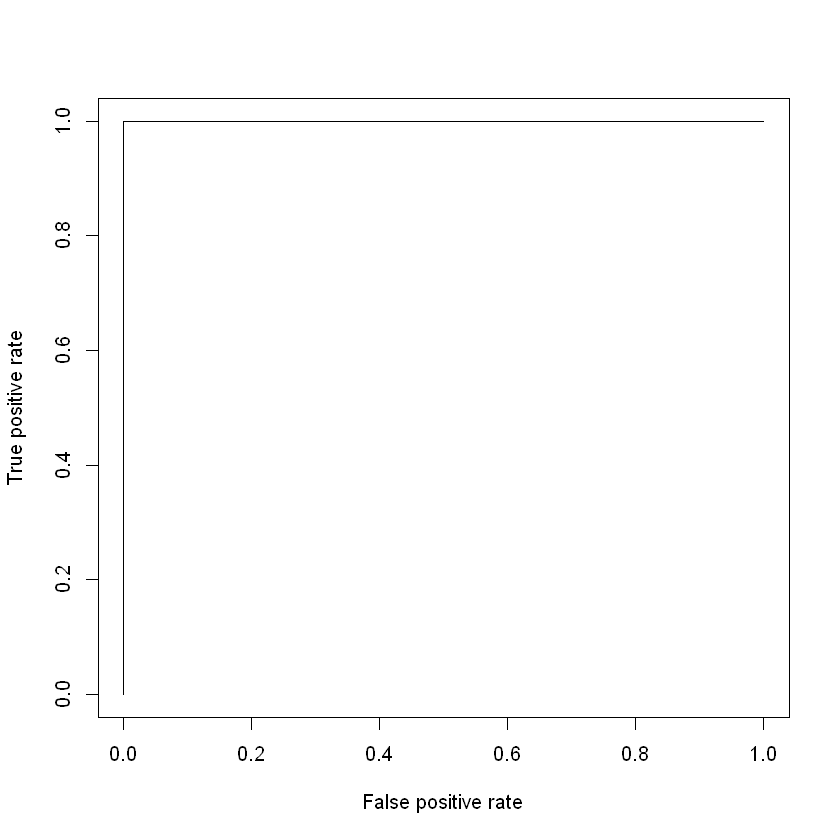

In [225]:
prf<-performance(pr,measure = "tpr",x.measure = "fpr")
plot(prf)

In [226]:
pred<-predict(model_rforest1,test2,type="response")
pred_test2<-ifelse(pred>0.5,1,0)
library(caret)
confusionMatrix(as.factor(test2$event),as.factor(pred_test2))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  74   0
         1   0 194
                                     
               Accuracy : 1          
                 95% CI : (0.9863, 1)
    No Information Rate : 0.7239     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.2761     
         Detection Rate : 0.2761     
   Detection Prevalence : 0.2761     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [227]:
pr<-prediction(as.numeric(pred_test2),as.numeric(test2$event))
auc<-performance(pr,measure = "auc")
auc<-auc@y.values
auc

[[1]]
[1] 1

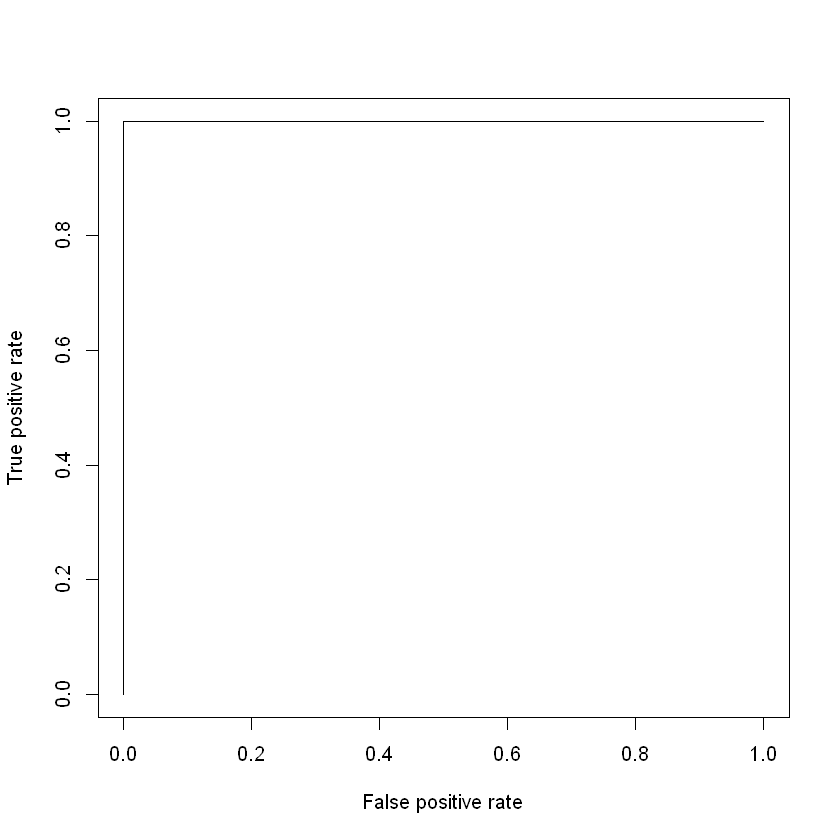

In [228]:
prf<-performance(pr,measure = "tpr",x.measure = "fpr")
plot(prf)